In [11]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Add the directory where dynamics.py and utils.py are located to sys.path
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm import tqdm
from dynamics import SatelliteDynamics
from scipy.optimize import approx_fprime
from scipy.linalg import block_diag, solve
from utils import get_form_initial_conditions

In [12]:
# Simulation parameters
dt = 60.0  # Time step [s]
T = 395  # Duration [min]
T_RMSE = 300  # Index from which the RMSE is calculated
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6  # Number of states
n_p = 3  
n_y_1 = 3  # Number of measurements
n_y_2 = 2
n_y_3 = 2
n_y_4 = 2
K = T
W = 100 # Window size [min]

In [13]:
# Initial state vector and get the true state vectors (propagation) F
X_initial = get_form_initial_conditions(formation)
X_true = np.zeros((24, 1, T))
X_true[:, :, 0] = X_initial
for t in range(T - 1):
    X_true[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_true[:, :, t])

# Process noise
q_chief_pos = 1e-1  # [m]
q_chief_vel = 1e-2 # [m / s]
Q_chief = (
    np.diag(np.concatenate([q_chief_pos * np.ones(3), q_chief_vel * np.ones(3)]))
    ** 2
)
q_deputy_pos = 1e0  # [m]
q_deputy_vel = 1e-2  # [m / s]
Q_deputy = (
    np.diag(np.concatenate([q_deputy_pos * np.ones(3), q_deputy_vel * np.ones(3)]))
    ** 2
)
Q_deputies = block_diag(Q_deputy, Q_deputy, Q_deputy)
Q = block_diag(Q_chief, Q_deputies)

# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(6)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])

In [14]:
def h_function_chief(x_vec):
    """
    Computes the measurement vector based on the current state vector.
    The measurement vector includes position components.

    Parameters:
    x_vec (np.array): The current state vector of the satellite (position [km] and velocity [km / s]).
    """
    return x_vec[0:3]

def h_function_deputy(x_vec):
    """
    Computes the measurement vector based on the current state vector.

    Parameters:
    x_vec (np.array): The current state vector of the satellite (position [km] and velocity [km / s]).

    Returns:
    y (np.array): The measurement vector of the satellite (range [km]).
    """
    r_chief = x_vec[:3]
    r_deputy1 = x_vec[6:9]
    r_deputy2 = x_vec[12:15]
    r_deputy3 = x_vec[18:21]

    range_deputy1_chief = np.linalg.norm(r_deputy1 - r_chief)
    range_deputy1_deputy2 = np.linalg.norm(r_deputy1 - r_deputy2)
    range_deputy1_deputy3 = np.linalg.norm(r_deputy1 - r_deputy3)
    range_deputy2_chief = np.linalg.norm(r_deputy2 - r_chief)
    range_deputy2_deputy3 = np.linalg.norm(r_deputy2 - r_deputy3)
    range_deputy3_chief = np.linalg.norm(r_deputy3 - r_chief)

    return np.array(
        [
            [range_deputy1_chief],
            [range_deputy1_deputy2],
            [range_deputy1_deputy3],
            [range_deputy2_chief],
            [range_deputy2_deputy3],
            [range_deputy3_chief],
        ]
    )

def h(x_vec):
    return np.concatenate([h_function_chief(x_vec), h_function_deputy(x_vec)])

In [15]:
# Simulation setup
np.random.seed(42)
X_est = np.zeros_like(X_true)
initial_dev = np.concatenate(
    (
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
    )
)
X_est[:, :, 0] = X_initial + initial_dev
for t in range(T - 1):
    X_est[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_est[:, :, t])

# Observations
Y = np.zeros((9, 1, T))
for t in range(T):
    Y[:, :, t] = h(X_true[:, :, t]) + np.random.normal(0, np.sqrt(np.diag(R)).reshape((9, 1)), size=(9, 1))
    
dev_chief_initial = np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).reshape(-1, 1)
dev_deputy1_initial = np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).reshape(-1, 1)
dev_deputy2_initial = np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).reshape(-1, 1)
dev_deputy3_initial = np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).reshape(-1, 1)

In [16]:
def f(x_0, y):
    f_x_0 = 0

    # Extract x_1(0), x_2(0), x_3(0), x_4(0) from flattened state vector x_0
    x_1_k = x_0[:n_x, :]
    x_2_k = x_0[n_x:2*n_x, :]
    x_3_k = x_0[2*n_x:3*n_x, :]
    x_4_k = x_0[3*n_x:4*n_x, :]
    
    # Iterate over all sliding window time steps
    for k in range(W):    
        # Absolute residual term: observed data y for each state
        y_1_k = y[:n_y_1, :, k]
        y_rel_k = y[n_y_1:, :, k]

        # Update the cost function with the residuals for self-measurements
        residual = y_1_k - P @ x_1_k
        f_x_0 += 1 / 2 * residual.T @ np.linalg.inv(R_chief) @ residual

        # Pairwise relative measurements
        y_21_k = y_rel_k[0]
        y_23_k = y_rel_k[1]
        y_24_k = y_rel_k[2]
        y_31_k = y_rel_k[3]
        y_34_k = y_rel_k[4]
        y_41_k = y_rel_k[5]

        # Process pairwise relative residuals for each pair
        pairs = [
            (2, 1, x_2_k, x_1_k, y_21_k),  # (2, 1)
            (2, 3, x_2_k, x_3_k, y_23_k),  # (2, 3)
            (2, 4, x_2_k, x_4_k, y_24_k),  # (2, 4)
            (3, 1, x_3_k, x_1_k, y_31_k),  # (3, 1)
            (3, 4, x_3_k, x_4_k, y_34_k),  # (3, 4)
            (4, 1, x_4_k, x_1_k, y_41_k),  # (4, 1)
        ]

        # Iterate over each pair and update the cost function with the residuals for pairwise measurements
        for i, j, x_i_k, x_j_k, y_ij_k in pairs:
            d_ij_k_vec = P @ x_i_k - P @ x_j_k
            d_ij_k = np.linalg.norm(d_ij_k_vec)
            f_x_0 += (y_ij_k - d_ij_k) ** 2 / (2 * r_deputy_pos**2)

        if k < W - 1:
            # Get x_1(k), x_2(k), x_3(k), x_4(k) from the state vector x_0
            x_1_k = SatelliteDynamics().x_new(dt, x_1_k)
            x_2_k = SatelliteDynamics().x_new(dt, x_2_k)
            x_3_k = SatelliteDynamics().x_new(dt, x_3_k)
            x_4_k = SatelliteDynamics().x_new(dt, x_4_k)

    return f_x_0

def grad_f(x_0, y):
    grad_f_x_0 = np.zeros_like(x_0)

    # Extract x_1(0), x_2(0), x_3(0), x_4(0) from flattened state vector x_0
    x_1_k = x_0[:n_x, :]
    x_2_k = x_0[n_x:2*n_x, :]
    x_3_k = x_0[2*n_x:3*n_x, :]
    x_4_k = x_0[3*n_x:4*n_x, :]
    STM_t0_1 = np.eye(n_x)
    STM_t0_2 = np.eye(n_x)
    STM_t0_3 = np.eye(n_x)
    STM_t0_4 = np.eye(n_x)
    
    # Iterate over all sliding window time steps
    for k in range(W):
        # Absolute residual term: observed data y for each state
        y_1_k = y[:n_y_1, :, k]
        y_rel_k = y[n_y_1:, :, k]

        # Compute gradients for the absolute residual terms
        grad_f_x_0[:n_x, :] -= STM_t0_1.T @ P.T @ np.linalg.inv(R_chief) @ (y_1_k - P @ x_1_k)

        # Pairwise relative measurements
        y_21_k = y_rel_k[0]
        y_23_k = y_rel_k[1]
        y_24_k = y_rel_k[2]
        y_31_k = y_rel_k[3]
        y_34_k = y_rel_k[4]
        y_41_k = y_rel_k[5]

        # Process pairwise relative residuals for each pair
        pairs = [
            (2, 1, x_2_k, x_1_k, y_21_k, STM_t0_2, STM_t0_1),  # (2, 1)
            (2, 3, x_2_k, x_3_k, y_23_k, STM_t0_2, STM_t0_3),  # (2, 3)
            (2, 4, x_2_k, x_4_k, y_24_k, STM_t0_2, STM_t0_4),  # (2, 4)
            (3, 1, x_3_k, x_1_k, y_31_k, STM_t0_3, STM_t0_1),  # (3, 1)
            (3, 4, x_3_k, x_4_k, y_34_k, STM_t0_3, STM_t0_4),  # (3, 4)
            (4, 1, x_4_k, x_1_k, y_41_k, STM_t0_4, STM_t0_1),  # (4, 1)
        ]

        # Iterate over each pair and compute gradients
        for i, j, x_i_k, x_j_k, y_ij_k, STM_t0_i, STM_t0_j in pairs:
            d_ij_k_vec = P @ x_i_k - P @ x_j_k
            d_ij_k = np.linalg.norm(d_ij_k_vec)

            # Update the gradient of f(x) with respect to x_i(k) and x_j(k)
            grad_f_x_0[(i - 1) * n_x:i * n_x, :] -= (y_ij_k - d_ij_k) / r_deputy_pos**2 * (STM_t0_i.T @ P.T @ d_ij_k_vec) / d_ij_k
            grad_f_x_0[(j - 1) * n_x:j * n_x, :] += (y_ij_k - d_ij_k) / r_deputy_pos**2 * (STM_t0_j.T @ P.T @ d_ij_k_vec) / d_ij_k

        if k < W - 1:
            # Get x_1(k), x_2(k), x_3(k), x_4(k) from the state vector x_0
            STM_t0_1_old = STM_t0_1
            STM_t0_2_old = STM_t0_2
            STM_t0_3_old = STM_t0_3
            STM_t0_4_old = STM_t0_4
            x_1_k, STM_t0_1 = SatelliteDynamics().x_new_and_F(dt, x_1_k)
            x_2_k, STM_t0_2 = SatelliteDynamics().x_new_and_F(dt, x_2_k)
            x_3_k, STM_t0_3 = SatelliteDynamics().x_new_and_F(dt, x_3_k)
            x_4_k, STM_t0_4 = SatelliteDynamics().x_new_and_F(dt, x_4_k)
            STM_t0_1 = STM_t0_1 @ STM_t0_1_old
            STM_t0_2 = STM_t0_2 @ STM_t0_2_old
            STM_t0_3 = STM_t0_3 @ STM_t0_3_old
            STM_t0_4 = STM_t0_4 @ STM_t0_4_old

    return grad_f_x_0

def hessian_f(x_0, y):
    hessian_f_x_0 = np.zeros((x_0.shape[0], x_0.shape[0]))  # Initialize Hessian matrix
    
    # Extract x_1(0), x_2(0), x_3(0), x_4(0) from flattened state vector x_0
    x_1_k = x_0[:n_x, :]
    x_2_k = x_0[n_x:2*n_x, :]
    x_3_k = x_0[2*n_x:3*n_x, :]
    x_4_k = x_0[3*n_x:4*n_x, :]
    STM_t0_1 = np.eye(n_x)
    STM_t0_2 = np.eye(n_x)
    STM_t0_3 = np.eye(n_x)
    STM_t0_4 = np.eye(n_x)

    # Iterate over all sliding window time steps
    for k in range(W):
        # Absolute residual term: observed data y for each state
        y_rel_k = y[n_y_1:, :, k]

        # Absolute measurement residuals' Hessian
        hessian_f_x_0[:n_x, :n_x] += STM_t0_1.T @ P.T @ np.linalg.inv(R_chief) @ P @ STM_t0_1 

        # Pairwise relative measurements
        y_21_k = y_rel_k[0]
        y_23_k = y_rel_k[1]
        y_24_k = y_rel_k[2]
        y_31_k = y_rel_k[3]
        y_34_k = y_rel_k[4]
        y_41_k = y_rel_k[5]

        # Process pairwise relative residuals for each pair in the tree
        pairs = [
            (2, 1, x_2_k, x_1_k, y_21_k, STM_t0_2, STM_t0_1),  # (2, 1)
            (3, 1, x_3_k, x_1_k, y_31_k, STM_t0_3, STM_t0_1),  # (3, 1)
            (4, 1, x_4_k, x_1_k, y_41_k, STM_t0_4, STM_t0_1),  # (4, 1)
        ]

        # Iterate over each pair and compute gradients
        for i, j, x_i_k, x_j_k, y_ij_k, STM_t0_i, STM_t0_j in pairs:
            d_ij_k_vec = P @ x_i_k - P @ x_j_k
            d_ij_k = np.linalg.norm(d_ij_k_vec)

            # Update the Hessian for x_i(k) and x_j(k)
            idx_i = n_x * (i - 1)
            idx_j = n_x * (j - 1)
            
            hessian_f_x_0[idx_i:idx_i + n_x, idx_i:idx_i + n_x] -= 1 / (r_deputy_pos ** 2) * (STM_t0_i.T @ ((y_ij_k - d_ij_k) / d_ij_k * P.T @ P - y_ij_k / d_ij_k**3 * P.T @ d_ij_k_vec @ d_ij_k_vec.T @ P) @ STM_t0_i)
            hessian_f_x_0[idx_i:idx_i + n_x, idx_j:idx_j + n_x] += 1 / (r_deputy_pos ** 2) * (STM_t0_i.T @ ((y_ij_k - d_ij_k) / d_ij_k * P.T @ P - y_ij_k / d_ij_k**3 * P.T @ d_ij_k_vec @ d_ij_k_vec.T @ P) @ STM_t0_j)
            hessian_f_x_0[idx_j:idx_j + n_x, idx_i:idx_i + n_x] += 1 / (r_deputy_pos ** 2) * (STM_t0_j.T @ ((y_ij_k - d_ij_k) / d_ij_k * P.T @ P - y_ij_k / d_ij_k**3 * P.T @ d_ij_k_vec @ d_ij_k_vec.T @ P) @ STM_t0_i)
            hessian_f_x_0[idx_j:idx_j + n_x, idx_j:idx_j + n_x] -= 1 / (r_deputy_pos ** 2) * (STM_t0_j.T @ ((y_ij_k - d_ij_k) / d_ij_k * P.T @ P - y_ij_k / d_ij_k**3 * P.T @ d_ij_k_vec @ d_ij_k_vec.T @ P) @ STM_t0_j)
            
        # Process pairwise relative residuals for each pair in the residual set of edges
        pairs = [
            (2, 3, x_2_k, x_3_k, y_23_k, STM_t0_2, STM_t0_3),  # (2, 3)
            (2, 4, x_2_k, x_4_k, y_24_k, STM_t0_2, STM_t0_4),  # (2, 4)
            (3, 4, x_3_k, x_4_k, y_34_k, STM_t0_3, STM_t0_4),  # (3, 4)
        ]

        # Iterate over each pair and compute gradients
        for i, j, x_i_k, x_j_k, y_ij_k, STM_t0_i, STM_t0_j in pairs:
            d_ij_k_vec = P @ x_i_k - P @ x_j_k
            d_ij_k = np.linalg.norm(d_ij_k_vec)

            # Update the Hessian for x_i(k) and x_j(k)
            idx_i = n_x * (i - 1)
            idx_j = n_x * (j - 1)
            
            hessian_f_x_0[idx_i:idx_i + n_x, idx_i:idx_i + n_x] -= 1 / (r_deputy_pos ** 2) * (STM_t0_i.T @ ((y_ij_k - d_ij_k) / d_ij_k * P.T @ P - y_ij_k / d_ij_k**3 * P.T @ d_ij_k_vec @ d_ij_k_vec.T @ P) @ STM_t0_i)
            # hessian_f_x_0[idx_i:idx_i + n_x, idx_j:idx_j + n_x] += 1 / (r_deputy_pos ** 2) * (STM_t0_i.T @ ((y_ij_k - d_ij_k) / d_ij_k * P.T @ P - y_ij_k / d_ij_k**3 * P.T @ d_ij_k_vec @ d_ij_k_vec.T @ P) @ STM_t0_j)
            # hessian_f_x_0[idx_j:idx_j + n_x, idx_i:idx_i + n_x] += 1 / (r_deputy_pos ** 2) * (STM_t0_j.T @ ((y_ij_k - d_ij_k) / d_ij_k * P.T @ P - y_ij_k / d_ij_k**3 * P.T @ d_ij_k_vec @ d_ij_k_vec.T @ P) @ STM_t0_i)
            hessian_f_x_0[idx_j:idx_j + n_x, idx_j:idx_j + n_x] -= 1 / (r_deputy_pos ** 2) * (STM_t0_j.T @ ((y_ij_k - d_ij_k) / d_ij_k * P.T @ P - y_ij_k / d_ij_k**3 * P.T @ d_ij_k_vec @ d_ij_k_vec.T @ P) @ STM_t0_j)

        if k < W - 1:
            # Get x_1(k), x_2(k), x_3(k), x_4(k) from the state vector x_0
            STM_t0_1_old = STM_t0_1
            STM_t0_2_old = STM_t0_2
            STM_t0_3_old = STM_t0_3
            STM_t0_4_old = STM_t0_4
            x_1_k, STM_t0_1 = SatelliteDynamics().x_new_and_F(dt, x_1_k)
            x_2_k, STM_t0_2 = SatelliteDynamics().x_new_and_F(dt, x_2_k)
            x_3_k, STM_t0_3 = SatelliteDynamics().x_new_and_F(dt, x_3_k)
            x_4_k, STM_t0_4 = SatelliteDynamics().x_new_and_F(dt, x_4_k)
            STM_t0_1 = STM_t0_1 @ STM_t0_1_old
            STM_t0_2 = STM_t0_2 @ STM_t0_2_old
            STM_t0_3 = STM_t0_3 @ STM_t0_3_old
            STM_t0_4 = STM_t0_4 @ STM_t0_4_old

    return hessian_f_x_0

In [17]:
def L(x_0, y):
    """
    Lagrangian wrapper for the cost function.
    """
    return f(x_0, y)
    
def grad_L(x_0, y):
    """
    Gradient of Lagrangian wrapper.
    """
    return grad_f(x_0, y)

def hessian_L(x_0, y):
    """
    Hessian of Lagrangian wrapper.
    """
    return hessian_f(x_0, y)

In [18]:
class approxH_Newton:
    def __init__(self, grad_tol=1e0, max_iter=20):
        self.grad_tol = grad_tol
        self.max_iter = max_iter
        
        # Storage for results
        self.cost_function_values = []
        self.grad_norm_values = []

    def solve(self, x_init, Y, X_true):
        x = x_init
            
        prev_cost_function_value = None
        prev_grad_norm_value = None
        prev_global_error = None
        
        for iteration in range(self.max_iter):
            # Compute the cost function, gradient and approximated Hessian
            L_x = L(x, Y)
            grad_L_x = grad_L(x, Y)
            hessian_L_x = hessian_L(x, Y)

            # Convergence tracking
            cost_function_value = L_x[0][0]
            grad_norm_value = np.linalg.norm(grad_L_x)

            # Store the norms
            self.cost_function_values.append(cost_function_value)
            self.grad_norm_values.append(grad_norm_value)
            
            if prev_cost_function_value is not None:
                cost_function_change = (cost_function_value - prev_cost_function_value) / abs(prev_cost_function_value) * 100
                grad_norm_change = (grad_norm_value - prev_grad_norm_value) / abs(prev_grad_norm_value) * 100
                global_error_change = (np.linalg.norm(x - X_true) - prev_global_error) / abs(prev_global_error) * 100
            prev_cost_function_value = cost_function_value
            prev_grad_norm_value = grad_norm_value
            prev_global_error = np.linalg.norm(x - X_true)

            # Check convergence and print metrics
            if grad_norm_value < self.grad_tol or iteration + 1 == self.max_iter:
                print(f"STOP on Iteration {iteration}\nCost function = {cost_function_value} ({cost_function_change:.2f}%)\nGradient norm = {grad_norm_value} ({grad_norm_change:.2f}%)\nGlobal relative error = {np.linalg.norm(x - X_true)} ({global_error_change:.2f}%)")
                print(f"Final position relative errors: {np.linalg.norm(x[0:3, :] - X_true[0:3, :])} m, {np.linalg.norm(x[6:9, :] - X_true[6:9, :])} m, {np.linalg.norm(x[12:15, :] - X_true[12:15, :])} m, {np.linalg.norm(x[18:21, :] - X_true[18:21, :])} m\n")
                break
            else:
                if iteration == 0:
                    print(f"Before applying the algorithm\nCost function: {cost_function_value}\nGradient norm: {grad_norm_value}\nGlobal relative error: {np.linalg.norm(x - X_true)}")
                else:
                    print(f"Iteration {iteration}\nCost function: {cost_function_value} ({cost_function_change:.2f}%)\nGradient norm: {grad_norm_value} ({grad_norm_change:.2f}%)\nGlobal relative error: {np.linalg.norm(x - X_true)} ({global_error_change:.2f}%)")
                    
            # Print relative errors 
            print(f"Position relative errors: {np.linalg.norm(x[0:3, :] - X_true[0:3, :])} m, {np.linalg.norm(x[6:9, :] - X_true[6:9, :])} m, {np.linalg.norm(x[12:15, :] - X_true[12:15, :])} m, {np.linalg.norm(x[18:21, :] - X_true[18:21, :])} m\n")
            
            # Solve for the Newton step
            delta_x = solve(hessian_L_x, -grad_L_x)
            x += delta_x

        return x

In [19]:
def give_me_the_plots(cost_function_values, grad_norm_values):
    iterations = np.arange(0, len(cost_function_values))

    # Plot 1
    plt.semilogy(iterations, cost_function_values, '.-')
    plt.xlabel(r'$m$')
    plt.ylabel(r'$L(x^{(m)})$')
    plt.grid(True)
    plt.grid(True, which="minor", linestyle='--')
    plt.show()
    
    # Plot 2
    plt.semilogy(iterations, grad_norm_values, '.-')
    plt.xlabel(r'$m$')
    plt.ylabel(r'$||\nabla L(x^{(m)})||_2$')
    plt.grid(True)
    plt.grid(True, which="minor", linestyle='--')
    plt.show()

Windows:   0%|          | 0/386 [00:00<?, ?it/s]

Before applying the algorithm
Cost function: 4548756.93856041
Gradient norm: 26685148.58225711
Global relative error: 395.60563949432424
Position relative errors: 82.78540989608044 m, 181.7491507333766 m, 258.73787052498585 m, 222.8729633755392 m

Iteration 1
Cost function: 2726392.193873033 (-40.06%)
Gradient norm: 3555793.069811512 (-86.68%)
Global relative error: 362.7000802291601 (-8.32%)
Position relative errors: 2.117317906288559 m, 105.63216451526307 m, 292.31202314575637 m, 186.86057379305097 m

Iteration 2
Cost function: 1175410.109452266 (-56.89%)
Gradient norm: 1942047.5316718572 (-45.38%)
Global relative error: 390.1799689709949 (7.58%)
Position relative errors: 0.7007925757989149 m, 164.50656892696767 m, 221.12052530586877 m, 276.1619186466727 m

Iteration 3
Cost function: 5438427.372490041 (362.68%)
Gradient norm: 5561521.423137544 (186.37%)
Global relative error: 489.27577101160756 (25.40%)
Position relative errors: 0.721339426665745 m, 277.9869159641041 m, 286.998422135

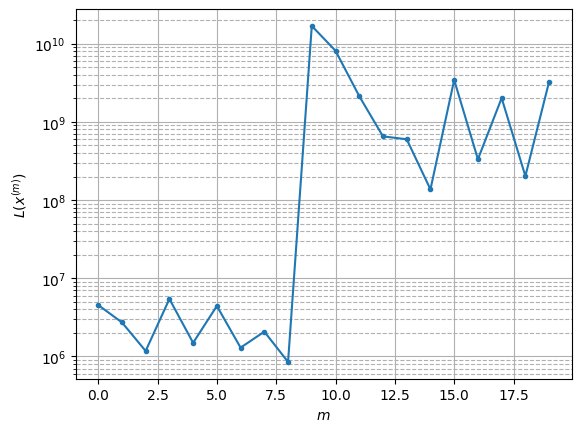

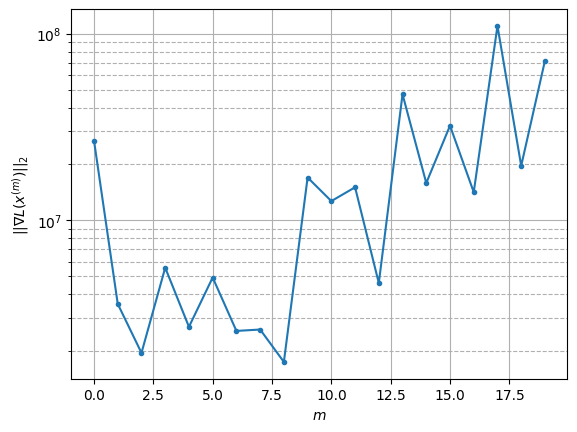

Windows:   0%|          | 1/386 [00:03<20:49,  3.25s/it]

Before applying the algorithm
Cost function: 2399227553.321492
Gradient norm: 63287685.79240139
Global relative error: 21299.971704749274
Position relative errors: 112.1397391823294 m, 2856.6275140912035 m, 10345.017152216536 m, 18398.183229255985 m

Iteration 1
Cost function: 208704343.7300775 (-91.30%)
Gradient norm: 16438646.150464976 (-74.03%)
Global relative error: 8440.972234500532 (-60.37%)
Position relative errors: 73.04441751705743 m, 5450.624669043096 m, 5467.521348408959 m, 3411.8236696652093 m

Iteration 2
Cost function: 162256063.32928336 (-22.26%)
Gradient norm: 23800818.643274896 (44.79%)
Global relative error: 7096.605074175085 (-15.93%)
Position relative errors: 21.820858150984495 m, 3015.988011908458 m, 2603.0971581448493 m, 5872.6618644965065 m

Iteration 3
Cost function: 114638022.82808156 (-29.35%)
Gradient norm: 27778689.07291617 (16.71%)
Global relative error: 5161.391992900375 (-27.27%)
Position relative errors: 38.331996705734674 m, 3102.123051459487 m, 3190.46

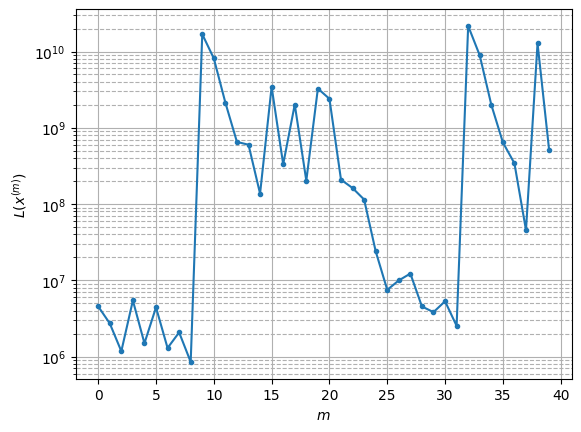

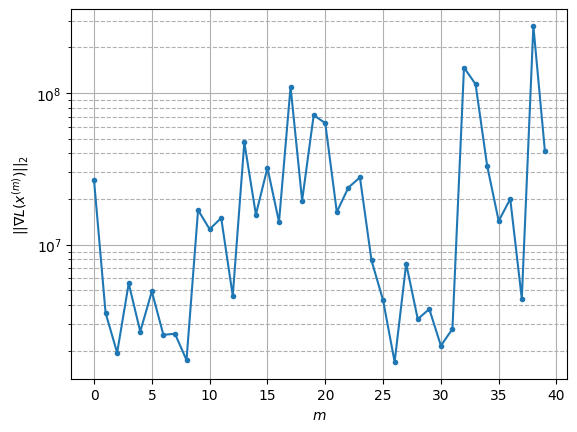

Windows:   1%|          | 2/386 [00:06<20:38,  3.23s/it]

Before applying the algorithm
Cost function: 579713028.460857
Gradient norm: 51163039.96119663
Global relative error: 10652.852657415728
Position relative errors: 78.60310614432291 m, 2887.546740081727 m, 7567.676238773353 m, 6918.618567246696 m

Iteration 1
Cost function: 110468303.71437114 (-80.94%)
Gradient norm: 19356987.57081885 (-62.17%)
Global relative error: 6522.020245187605 (-38.78%)
Position relative errors: 22.79830567817523 m, 4423.782476635249 m, 3198.6009823490926 m, 3568.59574187477 m

Iteration 2
Cost function: 193969047107952.2 (175587865.58%)
Gradient norm: 18585465754.517586 (95914.25%)
Global relative error: 5980741.910471677 (91600.76%)
Position relative errors: 22116.350696266443 m, 14454.626623041839 m, 194540.21868793198 m, 5977501.385150077 m

Iteration 3
Cost function: 30380471903846.44 (-84.34%)
Gradient norm: 6458852667.362728 (-65.25%)
Global relative error: 2941569.3034033445 (-50.82%)
Position relative errors: 39472.34486513674 m, 2133926.297231946 m, 20

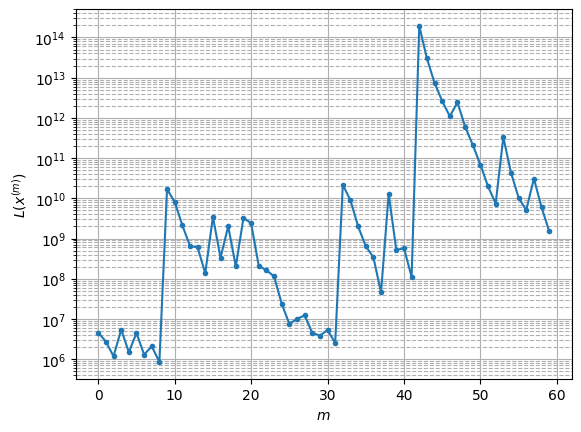

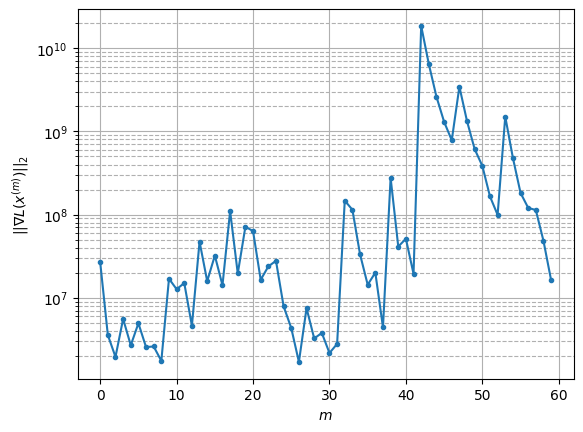

Windows:   1%|          | 3/386 [00:09<21:18,  3.34s/it]

Before applying the algorithm
Cost function: 1057203667.484338
Gradient norm: 14799448.500700353
Global relative error: 31958.47366443234
Position relative errors: 435.25634637570516 m, 19772.488029144457 m, 15240.21382800163 m, 19948.267059575028 m

Iteration 1
Cost function: 136231705660.7088 (12786.04%)
Gradient norm: 953230742.4349282 (6340.99%)
Global relative error: 49121.085928474546 (53.70%)
Position relative errors: 562.9966674817281 m, 45372.06685238093 m, 15416.150641354316 m, 10775.222762596533 m

Iteration 2
Cost function: 17158797463.791084 (-87.40%)
Gradient norm: 292096006.79211056 (-69.36%)
Global relative error: 30222.90613594474 (-38.47%)
Position relative errors: 382.185792085645 m, 9089.5163603854 m, 18164.313516535363 m, 22375.631476221868 m

Iteration 3
Cost function: 3513049003.1258755 (-79.53%)
Gradient norm: 104253467.50944215 (-64.31%)
Global relative error: 21622.429669219455 (-28.46%)
Position relative errors: 288.62047925959297 m, 12908.976028830866 m, 116

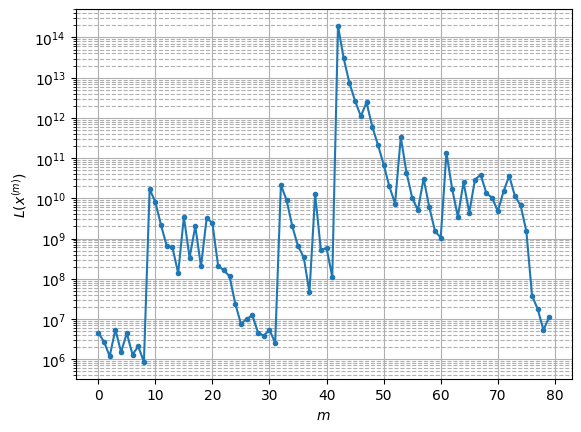

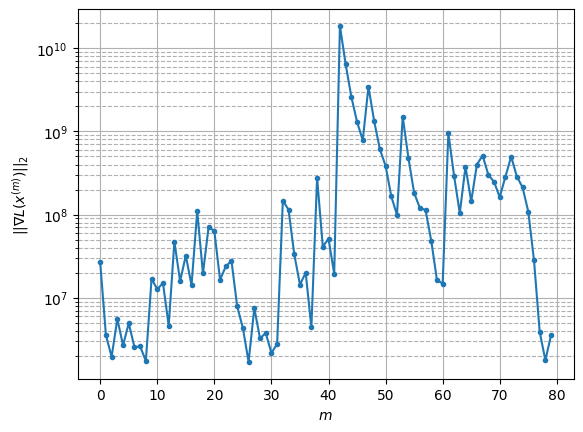

Windows:   1%|          | 4/386 [00:13<21:22,  3.36s/it]

Before applying the algorithm
Cost function: 8618003.43785417
Gradient norm: 3687926.234148331
Global relative error: 4845.192979858463
Position relative errors: 3.2471439390093306 m, 1185.9246121915785 m, 3516.1168014309405 m, 3115.4282486040174 m

Iteration 1
Cost function: 2885668.1031394177 (-66.52%)
Gradient norm: 1782156.7673744198 (-51.68%)
Global relative error: 4776.126848151854 (-1.43%)
Position relative errors: 6.558570452853264 m, 1193.2325176757256 m, 2904.235623124599 m, 3598.9650580302236 m

Iteration 2
Cost function: 7919991.783866113 (174.46%)
Gradient norm: 4969634.164300069 (178.86%)
Global relative error: 4687.248988116946 (-1.86%)
Position relative errors: 3.3273878064905555 m, 1921.0183903062666 m, 3454.639603609882 m, 2518.9292050509293 m

Iteration 3
Cost function: 2862018.0793073424 (-63.86%)
Gradient norm: 2615182.519986084 (-47.38%)
Global relative error: 4515.810600725386 (-3.66%)
Position relative errors: 5.67301416911108 m, 1313.7599066869288 m, 3162.68794

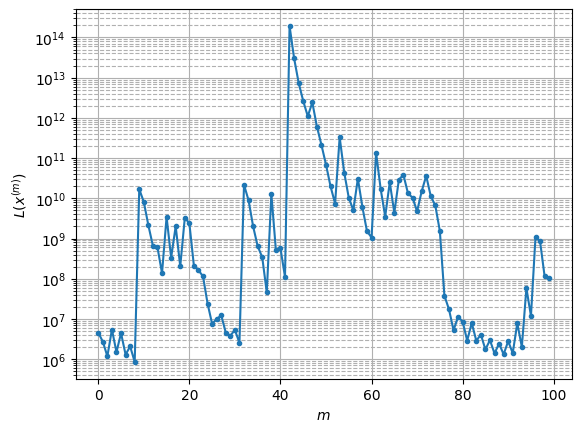

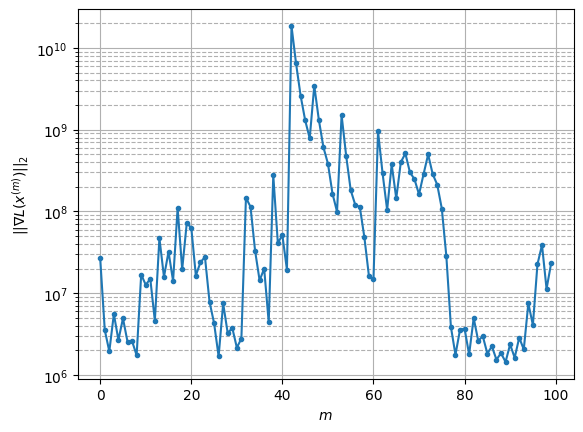

Windows:   1%|▏         | 5/386 [00:16<21:35,  3.40s/it]

Before applying the algorithm
Cost function: 135750804.5462762
Gradient norm: 29131066.9881808
Global relative error: 10195.478467733255
Position relative errors: 51.30370516759366 m, 4102.0468896609655 m, 5966.73896072339 m, 7177.424963201363 m

Iteration 1
Cost function: 31845752.242841918 (-76.54%)
Gradient norm: 13806149.203926437 (-52.61%)
Global relative error: 8205.212317295222 (-19.52%)
Position relative errors: 14.867355821624654 m, 2833.2942380546347 m, 4740.596783875884 m, 6068.279461515582 m

Iteration 2
Cost function: 180662925.28848976 (467.31%)
Gradient norm: 26635097.090155568 (92.92%)
Global relative error: 6431.035636340775 (-21.62%)
Position relative errors: 23.051391498284627 m, 2650.6328557018574 m, 2642.7251023140698 m, 5229.464623513843 m

Iteration 3
Cost function: 29530924.77032053 (-83.65%)
Gradient norm: 11484840.32299454 (-56.88%)
Global relative error: 4204.493174650878 (-34.62%)
Position relative errors: 10.016561607611393 m, 693.1302357969336 m, 2872.4505

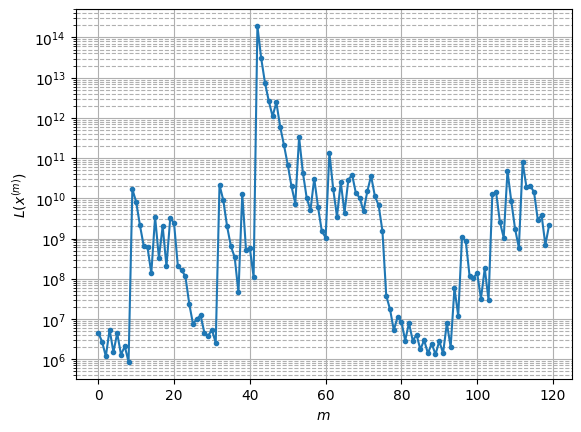

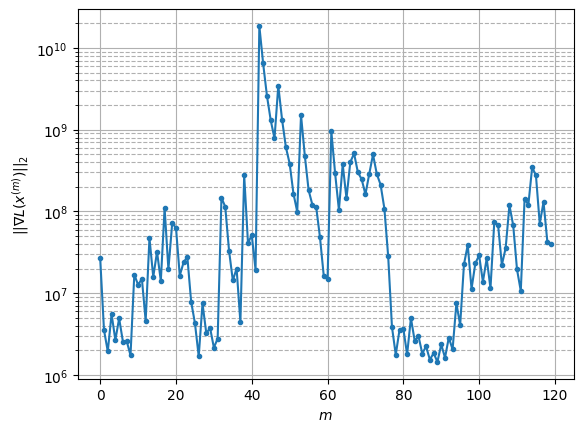

Windows:   2%|▏         | 6/386 [00:20<21:45,  3.44s/it]

Before applying the algorithm
Cost function: 1705383012.61726
Gradient norm: 34699667.37665294
Global relative error: 21345.51604709428
Position relative errors: 36.03083733782975 m, 4215.463116937813 m, 8822.210458688587 m, 18974.337035722005 m

Iteration 1
Cost function: 247875908.73486003 (-85.47%)
Gradient norm: 19886813.8080951 (-42.69%)
Global relative error: 9831.260443481213 (-53.94%)
Position relative errors: 47.14153785396221 m, 4667.73803996087 m, 7195.996679723134 m, 4804.204009889638 m

Iteration 2
Cost function: 112340132.2329877 (-54.68%)
Gradient norm: 11162866.834216677 (-43.87%)
Global relative error: 11428.894367872395 (16.25%)
Position relative errors: 57.8651647093114 m, 6097.710088112115 m, 5639.405706939003 m, 7850.482829876348 m

Iteration 3
Cost function: 72647362354.23572 (64567.33%)
Gradient norm: 80487239.5055684 (621.03%)
Global relative error: 135632.3381182134 (1086.75%)
Position relative errors: 1112.0216753877394 m, 118771.08591094305 m, 6002.4149374822

/tmp/ipykernel_15190/2490028760.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=1.50088e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 14
Cost function: 1.7886086412354063e+18 (-76.90%)
Gradient norm: 2332206480959.17 (-61.43%)
Global relative error: 504310051.62199575 (-41.33%)
Position relative errors: 8027984.26408494 m, 411377103.74663824 m, 204724108.66714045 m, 207638550.41532204 m

Iteration 15
Cost function: 5.992089280612334e+17 (-66.50%)
Gradient norm: 1088766454688.8462 (-53.32%)
Global relative error: 325101336.46995395 (-35.54%)
Position relative errors: 5440843.62400149 m, 139280323.18694156 m, 208161488.74468824 m, 207190782.5921561 m

Iteration 16
Cost function: 2.4804706802198803e+17 (-58.60%)
Gradient norm: 628659928021.5476 (-42.26%)
Global relative error: 216421572.86642578 (-33.43%)
Position relative errors: 3664746.5531883254 m, 139689283.89102837 m, 116693088.73018388 m, 117017713.50492468 m

Iteration 17
Cost function: 1.0977333188592726e+17 (-55.74%)
Gradient norm: 404118964755.8856 (-35.72%)
Global relative error: 145296699.42305738 (-32.86%)
Position relative errors: 2465560.358858

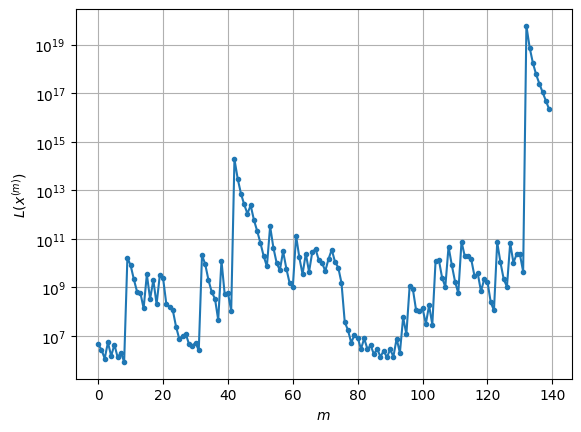

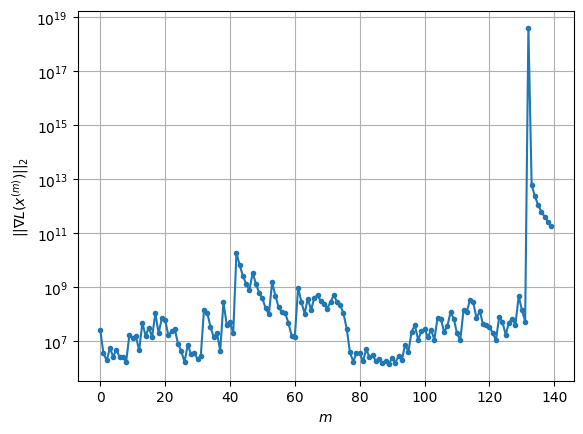

Windows:   2%|▏         | 7/386 [00:23<20:48,  3.29s/it]

Before applying the algorithm
Cost function: 3.0507336427224468e+16
Gradient norm: 235149420440.58545
Global relative error: 44526654.55797643
Position relative errors: 752272.3258321611 m, 25411385.06262928 m, 25848773.29267574 m, 25846373.21706292 m

Iteration 1
Cost function: 1.3720089254523772e+16 (-55.03%)
Gradient norm: 157672503583.1 (-32.95%)
Global relative error: 29547910.989783984 (-33.64%)
Position relative errors: 503750.3843141536 m, 17420506.87093131 m, 16870995.73655382 m, 16872012.91478109 m

Iteration 2
Cost function: 6075222149048182.0 (-55.72%)
Gradient norm: 105116073112.46513 (-33.33%)
Global relative error: 19024850.230131794 (-35.61%)
Position relative errors: 323123.3921275772 m, 11407023.28856435 m, 10763184.287717955 m, 10763350.009343304 m

Iteration 3
Cost function: 2494020857729038.0 (-58.95%)
Gradient norm: 68267996278.26756 (-35.05%)
Global relative error: 10451374.689930692 (-45.06%)
Position relative errors: 172802.29392746824 m, 7256877.701045201 m, 5

/tmp/ipykernel_15190/2490028760.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=1.12768e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 10
Cost function: 8.620367701225269e+20 (-89.22%)
Gradient norm: 67518942581086.484 (-100.00%)
Global relative error: 6763803380.7043295 (20097.45%)
Position relative errors: 93656898.38793246 m, 14837955.15939736 m, 4782153287.0995865 m, 4782161217.203364 m

Iteration 11
Cost function: 1.9359480199038278e+20 (-77.54%)
Gradient norm: 28427988762684.566 (-57.90%)
Global relative error: 3795236512.1139827 (-43.89%)
Position relative errors: 59469850.601402976 m, 3187672892.1167088 m, 1455751640.951929 m, 1455750481.8942297 m

Iteration 12
Cost function: 7.543475330181433e+19 (-61.03%)
Gradient norm: 15226363765941.814 (-46.44%)
Global relative error: 2498004653.173725 (-34.18%)
Position relative errors: 41118680.65616891 m, 984191839.5281354 m, 1623179235.9935346 m, 1623178263.0935843 m

Iteration 13
Cost function: 2.8000547491340203e+20 (271.19%)
Gradient norm: 37129310119200.164 (143.85%)
Global relative error: 4891515818.328364 (95.82%)
Position relative errors: 63376613.413

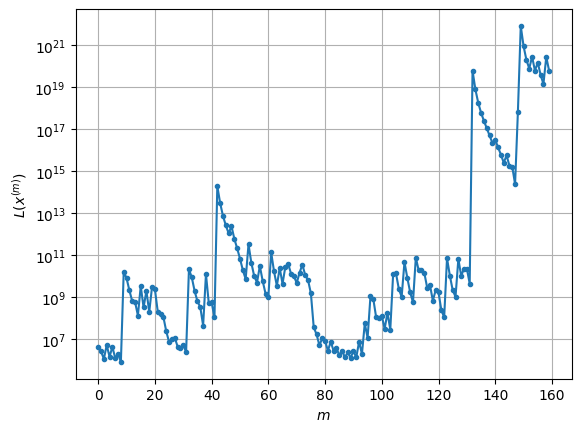

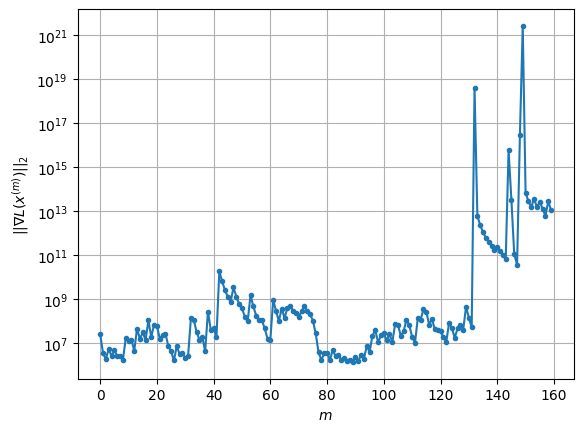

Windows:   2%|▏         | 8/386 [00:26<20:10,  3.20s/it]

Before applying the algorithm
Cost function: 5.134970004201575e+19
Gradient norm: 9979459675018.076
Global relative error: 3695599736.023299
Position relative errors: 58369295.7383639 m, 3027482228.64228 m, 1498161049.111629 m, 1497964659.599035 m

Iteration 1
Cost function: 1.7402300856821539e+19 (-66.11%)
Gradient norm: 4777426956832.527 (-52.13%)
Global relative error: 2376259723.290555 (-35.70%)
Position relative errors: 39192419.76072068 m, 1011761652.727008 m, 1520067449.0614414 m, 1520131719.7177238 m

Iteration 2
Cost function: 7.216014853872486e+18 (-58.53%)
Gradient norm: 2800603951141.7017 (-41.38%)
Global relative error: 1580227894.5127528 (-33.50%)
Position relative errors: 26321822.374815375 m, 1022173656.6042136 m, 851943355.2189796 m, 851925921.8199784 m

Iteration 3
Cost function: 3.1569068206966057e+18 (-56.25%)
Gradient norm: 1792798016978.1243 (-35.99%)
Global relative error: 1060775506.4080027 (-32.87%)
Position relative errors: 17650578.590081863 m, 573855188.4532

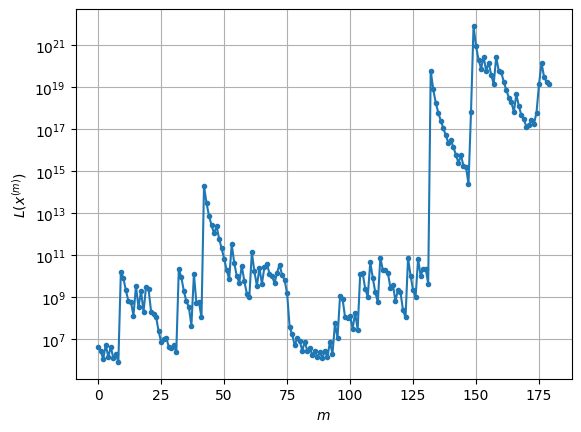

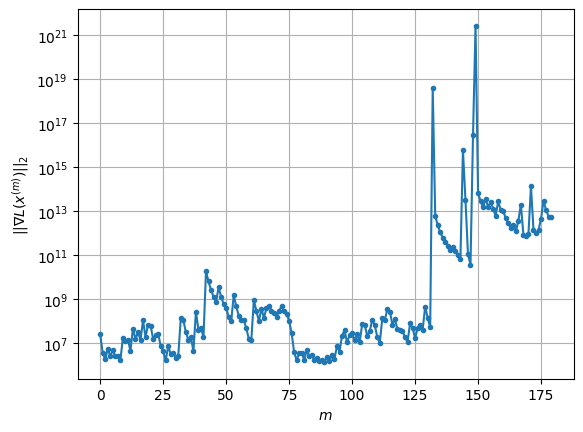

Windows:   2%|▏         | 9/386 [00:29<19:38,  3.13s/it]

Before applying the algorithm
Cost function: 1.606161756292607e+19
Gradient norm: 7472096512894.143
Global relative error: 1062609910.7940999
Position relative errors: 8378728.245797207 m, 563605530.4370118 m, 636940419.2010493 m, 636937569.666915 m

Iteration 1
Cost function: 7.4041721370687e+18 (-53.90%)
Gradient norm: 4885199474970.585 (-34.62%)
Global relative error: 702638199.0861946 (-33.88%)
Position relative errors: 4305331.89790679 m, 423656875.6915513 m, 396348214.3255159 m, 396350600.23688 m

Iteration 2
Cost function: 1.5144930095164367e+19 (104.55%)
Gradient norm: 7742245979458.095 (58.48%)
Global relative error: 1058205647.7048279 (50.60%)
Position relative errors: 11553299.169432111 m, 260471659.29023185 m, 725185796.7111617 m, 725182407.8963654 m

Iteration 3
Cost function: 2.4310285734131746e+23 (1605076.49%)
Gradient norm: 1.1203131869183525e+20 (1447013066.32%)
Global relative error: 915870072.1142719 (-13.45%)
Position relative errors: 7473029.040605695 m, 482239251

/tmp/ipykernel_15190/2490028760.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=5.76091e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 4
Cost function: 1.1131468007438215e+19 (-100.00%)
Gradient norm: 7441975693948.766 (-100.00%)
Global relative error: 1659910989.0084114 (81.24%)
Position relative errors: 17321082.514070675 m, 361097543.8215801 m, 1145555705.045093 m, 1145552694.0878563 m

Iteration 5
Cost function: 1.4223314153499806e+21 (12677.57%)
Gradient norm: 90080592487076.0 (1110.44%)
Global relative error: 5863485661.893248 (253.24%)
Position relative errors: 73871722.80152903 m, 744000609.5965283 m, 4112065574.2031093 m, 4112150228.3936143 m

Iteration 6
Cost function: 3.117168924567739e+20 (-78.08%)
Gradient norm: 34486608559402.18 (-61.72%)
Global relative error: 3231585223.274426 (-44.89%)
Position relative errors: 49651729.80624823 m, 2757930300.9621654 m, 1190316362.069216 m, 1190290025.207752 m

Iteration 7
Cost function: 1.0496258346933214e+20 (-66.33%)
Gradient norm: 31088582659522.367 (-9.85%)
Global relative error: 2039512310.118097 (-36.89%)
Position relative errors: 33827850.56582194 m,

/tmp/ipykernel_15190/2490028760.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=8.5795e-22): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 10
Cost function: 1.4826269576086012e+19 (-23.27%)
Gradient norm: 9224674355109.4 (-96.07%)
Global relative error: 1734691784.1824071 (91.04%)
Position relative errors: 25564142.375199724 m, 370542674.92926806 m, 1198177595.0775504 m, 1198127680.1526232 m

Iteration 11
Cost function: 1.3136052819145514e+26 (885998414.44%)
Gradient norm: 7.26152619679151e+24 (78718509914230.66%)
Global relative error: 1089374403.2625241 (-37.20%)
Position relative errors: 17684709.26779917 m, 804654808.0567905 m, 519092661.888406 m, 519105944.2469716 m



/tmp/ipykernel_15190/2490028760.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=6.55908e-24): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 12
Cost function: 5.568602446533804e+19 (-100.00%)
Gradient norm: 999532623314049.4 (-100.00%)
Global relative error: 1259281905.9687462 (15.60%)
Position relative errors: 18394428.289104767 m, 352036475.44917506 m, 854741561.277486 m, 854890254.4228567 m

Iteration 13
Cost function: 5.706582570087873e+19 (2.48%)
Gradient norm: 2.0093701338368573e+17 (20003.10%)
Global relative error: 774388290.8966287 (-38.51%)
Position relative errors: 16200648.382347295 m, 574441345.8455924 m, 367033593.9872376 m, 366991696.64565176 m

Iteration 14
Cost function: 4.3983001627734753e+18 (-92.29%)
Gradient norm: 36598960496493.7 (-99.98%)
Global relative error: 508522448.82000387 (-34.33%)
Position relative errors: 8993989.812524745 m, 248552325.44972575 m, 313618637.4014728 m, 313631154.28520143 m

Iteration 15
Cost function: 4.7657762766454057e+20 (10735.50%)
Gradient norm: 316888055229174.2 (765.84%)
Global relative error: 333390338.8645635 (-34.44%)
Position relative errors: 5438796.2598

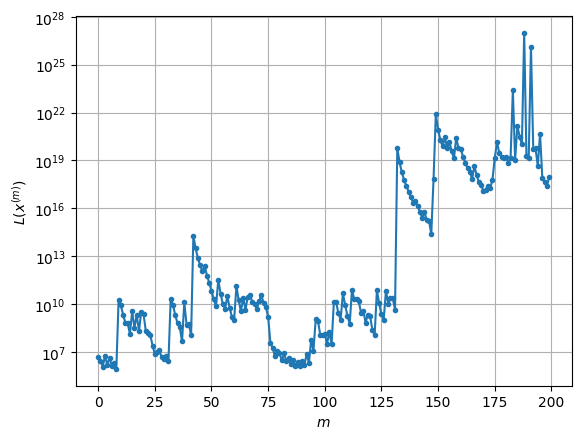

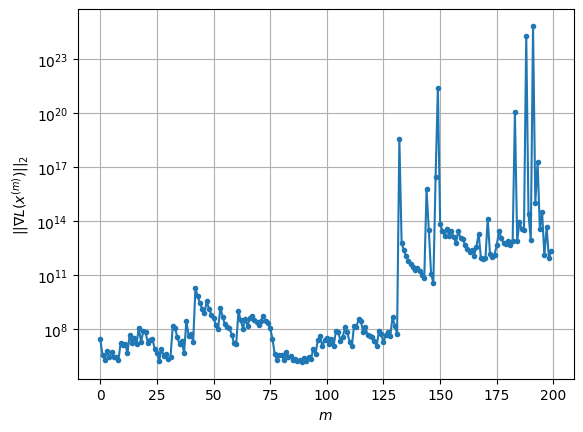

Windows:   3%|▎         | 10/386 [00:32<19:28,  3.11s/it]

Before applying the algorithm
Cost function: 1.0242801366099082e+18
Gradient norm: 2273302571762.13
Global relative error: 203735334.11509222
Position relative errors: 2315178.395452515 m, 54934111.437213585 m, 138717499.48720643 m, 138713369.03045556 m

Iteration 1
Cost function: 3.812630379559979e+17 (-62.78%)
Gradient norm: 1094195253205.2803 (-51.87%)
Global relative error: 180567170.12159005 (-11.37%)
Position relative errors: 1722139.2048293382 m, 92324522.40859032 m, 109720641.88041522 m, 109720182.27397852 m

Iteration 2
Cost function: 1.3318992804877233e+18 (249.34%)
Gradient norm: 2811752236639.1704 (156.97%)
Global relative error: 142795968.95941424 (-20.92%)
Position relative errors: 1552862.993258887 m, 73193979.64674091 m, 86693073.95110668 m, 86684570.16442372 m

Iteration 3
Cost function: 2.9323703355116006e+17 (-77.98%)
Gradient norm: 1091905634057.9777 (-61.17%)
Global relative error: 70478886.3684106 (-50.64%)
Position relative errors: 694012.5861452335 m, 57956665.8

/tmp/ipykernel_15190/2490028760.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=2.17811e-21): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 10
Cost function: 9.486578800969021e+20 (115705.15%)
Gradient norm: 4.088478612266147e+20 (3501819976.64%)
Global relative error: 185179201.79558793 (-35.56%)
Position relative errors: 3007384.0201599533 m, 79411426.01679754 m, 118274961.47638725 m, 118266616.57549483 m

Iteration 11
Cost function: 3.046795611512387e+16 (-100.00%)
Gradient norm: 112580761855835.86 (-100.00%)
Global relative error: 120755930.84055586 (-34.79%)
Position relative errors: 2541641.381274224 m, 79687374.79548049 m, 64132708.656470135 m, 64127877.57836484 m



/tmp/ipykernel_15190/2490028760.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=4.12113e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 12
Cost function: 2.674339740832743e+16 (-12.22%)
Gradient norm: 1189366036921.4075 (-98.94%)
Global relative error: 68233865.76252164 (-43.49%)
Position relative errors: 1380802.790540819 m, 43083637.72194794 m, 37405591.374374576 m, 37396854.45023717 m

Iteration 13
Cost function: 4.073103411460428e+16 (52.30%)
Gradient norm: 556054549688.2743 (-53.25%)
Global relative error: 37490683.57777791 (-45.06%)
Position relative errors: 504138.61329146504 m, 25055475.576667696 m, 19717261.188880995 m, 19715859.09291365 m

Iteration 14
Cost function: 1.7941661440972774e+16 (-55.95%)
Gradient norm: 324780053931.83545 (-41.59%)
Global relative error: 43832423.83791979 (16.92%)
Position relative errors: 645984.1375095159 m, 13230804.465618806 m, 29546903.1213311 m, 29542578.569357987 m

Iteration 15
Cost function: 4.8466533863171245e+17 (2601.34%)
Gradient norm: 1717338676635.5813 (428.77%)
Global relative error: 53942897.69023234 (23.07%)
Position relative errors: 611229.937617427 m, 

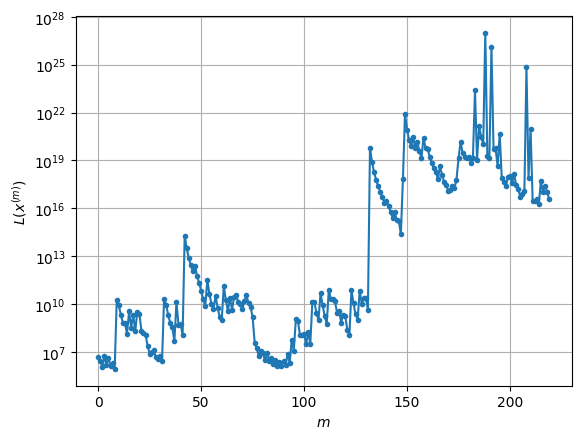

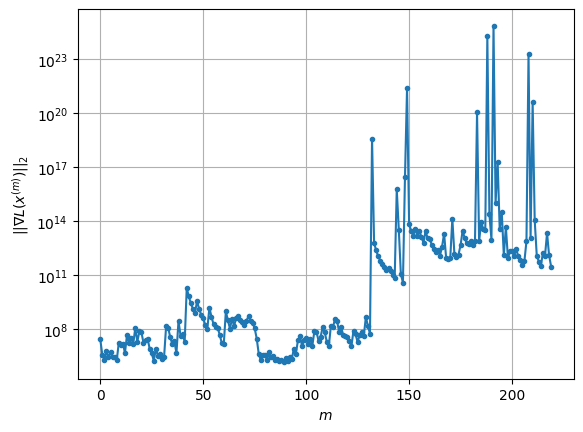

Windows:   3%|▎         | 11/386 [00:35<19:03,  3.05s/it]

Before applying the algorithm
Cost function: 5.331603607880719e+16
Gradient norm: 334598366833.8078
Global relative error: 8955992.943955693
Position relative errors: 162461.6644934676 m, 5256156.567273222 m, 5153213.384782678 m, 5089957.168656908 m

Iteration 1
Cost function: 2.4081464161164348e+16 (-54.83%)
Gradient norm: 219429249573.47845 (-34.42%)
Global relative error: 5972272.809951313 (-33.32%)
Position relative errors: 79217.11594923575 m, 3418848.1339826933 m, 3452847.4060719474 m, 3465397.060204835 m

Iteration 2
Cost function: 1.0887636041483504e+16 (-54.79%)
Gradient norm: 147624681860.48776 (-32.72%)
Global relative error: 3941713.9304185123 (-34.00%)
Position relative errors: 52485.17810334385 m, 2285233.221089091 m, 2273833.6067643077 m, 2263322.8990528965 m

Iteration 3
Cost function: 4912040562447727.0 (-54.88%)
Gradient norm: 99272618689.09923 (-32.75%)
Global relative error: 2543390.4423878076 (-35.48%)
Position relative errors: 33832.70081687328 m, 1457174.49076138

/tmp/ipykernel_15190/2490028760.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=5.81079e-21): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 17
Cost function: 4.299303192569888e+20 (-87.42%)
Gradient norm: 54697373673211.93 (-67.94%)
Global relative error: 2381377242.696937 (-54.27%)
Position relative errors: 31617413.069530647 m, 1604049319.0763702 m, 116907037.41001326 m, 1755781487.535361 m

Iteration 18
Cost function: 7.1165182838950126e+19 (-83.45%)
Gradient norm: 19412034228603.09 (-64.51%)
Global relative error: 1354638072.1401281 (-43.12%)
Position relative errors: 21322817.827003844 m, 555743743.1829221 m, 1126949718.5506754 m, 505541191.0763372 m

STOP on Iteration 19
Cost function = 1.8501578007194055e+19 (-74.00%)
Gradient norm = 7830078192374.123 (-59.66%)
Global relative error = 865909576.4238775 (-36.08%)
Final position relative errors: 14281676.33081853 m, 548839555.0653856 m, 358489364.82902706 m, 565507160.2654566 m



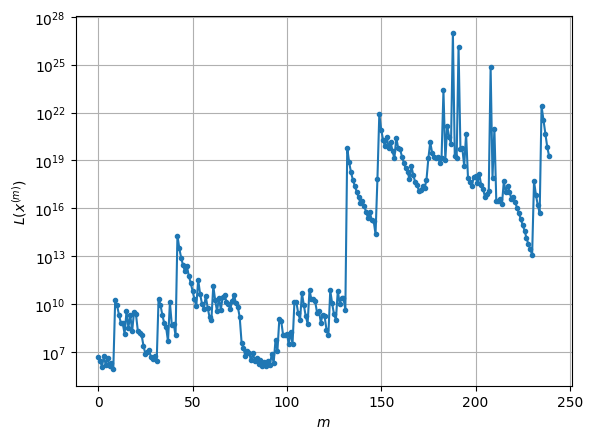

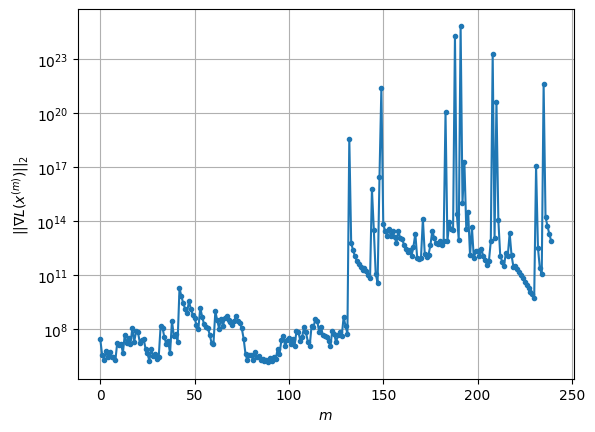

Windows:   3%|▎         | 12/386 [00:38<19:01,  3.05s/it]

Before applying the algorithm
Cost function: 2.6104144872011182e+19
Gradient norm: 9503722570979.691
Global relative error: 412651827.9223288
Position relative errors: 6845753.950070453 m, 264197525.22167796 m, 193755619.3999635 m, 250670109.19655284 m

Iteration 1
Cost function: 9.69090502856252e+18 (-62.88%)
Gradient norm: 4869734551990.551 (-48.76%)
Global relative error: 276082424.3701188 (-33.10%)
Position relative errors: 4475847.563268615 m, 149700008.09176984 m, 173172454.6307782 m, 154200441.3939737 m

Iteration 2
Cost function: 4.153029263348466e+18 (-57.15%)
Gradient norm: 2941458177253.036 (-39.60%)
Global relative error: 185606809.29579958 (-32.77%)
Position relative errors: 3213469.5247581727 m, 110190183.44525112 m, 102356454.56025766 m, 108672371.36319257 m

Iteration 3
Cost function: 3.989308232188969e+21 (95957.79%)
Gradient norm: 9.928144800629113e+19 (3375245850.26%)
Global relative error: 124944249.49274823 (-32.68%)
Position relative errors: 2196141.9049538737 m, 

/tmp/ipykernel_15190/2490028760.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=5.21005e-18): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/tmp/ipykernel_15190/2490028760.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=3.4647e-23): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 4
Cost function: 5.0030315217085065e+25 (1254010.04%)
Gradient norm: 4.2319018597306574e+24 (4262430.36%)
Global relative error: 84111261.47613904 (-32.68%)
Position relative errors: 1429844.2474040918 m, 48892216.81249117 m, 48019080.84182555 m, 48724664.07892436 m

Iteration 5
Cost function: 1.7490615128017306e+24 (-96.50%)
Gradient norm: 1.507599861855687e+23 (-96.44%)
Global relative error: 56661006.17791241 (-32.64%)
Position relative errors: 1522481.409029893 m, 32584929.1852285 m, 32870634.529551297 m, 32632165.741635807 m



/tmp/ipykernel_15190/2490028760.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=9.98706e-22): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 6
Cost function: 1.752901318315938e+17 (-100.00%)
Gradient norm: 1659819881402.5396 (-100.00%)
Global relative error: 38126129.901131734 (-32.71%)
Position relative errors: 254388.3512285642 m, 22046462.530202344 m, 21947537.285147205 m, 22030114.73798425 m

Iteration 7
Cost function: 7.866168428190395e+16 (-55.12%)
Gradient norm: 550086956603.8047 (-66.86%)
Global relative error: 25620522.11583496 (-32.80%)
Position relative errors: 224085.3169033299 m, 14774907.491040718 m, 14822184.511115327 m, 14769985.640574737 m

Iteration 8
Cost function: 5.684464903673861e+22 (72264624.00%)
Gradient norm: 2.8934939047415885e+21 (526006637578.85%)
Global relative error: 15979921.955176173 (-37.63%)
Position relative errors: 287785.4146604762 m, 8834965.788615424 m, 9963995.406971488 m, 8822833.371336313 m

Iteration 9
Cost function: 8.780462227272742e+19 (-99.85%)
Gradient norm: 134604894102773.34 (-100.00%)
Global relative error: 96105278.46608596 (501.41%)
Position relative errors: 6

/tmp/ipykernel_15190/2490028760.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=2.18073e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 10
Cost function: 4.2180826046322086e+17 (-99.52%)
Gradient norm: 1189162117917.3103 (-99.12%)
Global relative error: 41632586.508690886 (-56.68%)
Position relative errors: 817142.622557209 m, 27960368.671106588 m, 25612983.972435124 m, 17143461.01096295 m

Iteration 11
Cost function: 1.6161319195395414e+17 (-61.69%)
Gradient norm: 6777574832579.273 (469.95%)
Global relative error: 27095960.97232439 (-34.92%)
Position relative errors: 438019.1380481282 m, 13878854.378483074 m, 14658878.076821564 m, 18058348.64992296 m

Iteration 12
Cost function: 7.863734728351606e+20 (486477.53%)
Gradient norm: 6.941010917109727e+20 (10241142327.15%)
Global relative error: 18079583.126038123 (-33.28%)
Position relative errors: 225591.76201389558 m, 10953770.735652132 m, 10687788.801548725 m, 9614113.527137378 m

Iteration 13
Cost function: 3.212290316889324e+16 (-100.00%)
Gradient norm: 944299065374.7555 (-100.00%)
Global relative error: 12228850.872777183 (-32.36%)
Position relative errors:

/tmp/ipykernel_15190/2490028760.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=2.0829e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 14
Cost function: 1.4566841595258592e+16 (-54.65%)
Gradient norm: 781905745372149.9 (82702.77%)
Global relative error: 8325577.947151488 (-31.92%)
Position relative errors: 94443.04210777645 m, 4874540.171199818 m, 4842594.986993364 m, 4696594.785254892 m

Iteration 15
Cost function: 6621553866586214.0 (-54.54%)
Gradient norm: 16833822680445.924 (-97.85%)
Global relative error: 5819444.717345428 (-30.10%)
Position relative errors: 160887.4622744063 m, 3370726.188823755 m, 3372753.4148040274 m, 3329573.8967460073 m

Iteration 16
Cost function: 4.5545702615679416e+18 (68684.01%)
Gradient norm: 7.123522286071985e+18 (42316624.02%)
Global relative error: 5113499.200618229 (-12.13%)
Position relative errors: 146183.8952533061 m, 3215241.34538739 m, 3244282.3562031565 m, 2291946.630675007 m

Iteration 17
Cost function: 4.6288617855772626e+27 (101631142241.49%)
Gradient norm: 3.977110685253186e+26 (5583067553.24%)
Global relative error: 3464771.368458833 (-32.24%)
Position relative 

/tmp/ipykernel_15190/2490028760.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=1.11454e-18): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/tmp/ipykernel_15190/2490028760.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=3.40739e-25): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 18
Cost function: 7.044981611521112e+26 (-84.78%)
Gradient norm: 4.3222655724233844e+22 (-99.99%)
Global relative error: 1655206002398.0503 (47772345.17%)
Position relative errors: 14945917060.99584 m, 1170481468129.7676 m, 1169839262003.615 m, 2116441.0851573586 m

STOP on Iteration 19
Cost function = 1.1672724187382642e+26 (-83.43%)
Gradient norm = 1.9864312139571804e+16 (-100.00%)
Global relative error = 957556607593.516 (-42.15%)
Final position relative errors: 16351816366.196344 m, 395971192941.0152 m, 396185528014.8161 m, 776289955660.9159 m



/tmp/ipykernel_15190/2490028760.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=4.98469e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


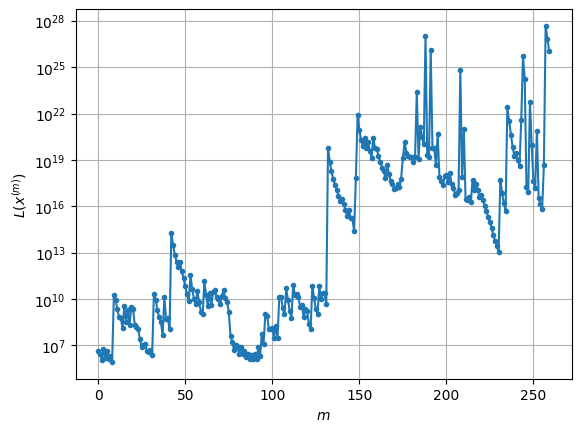

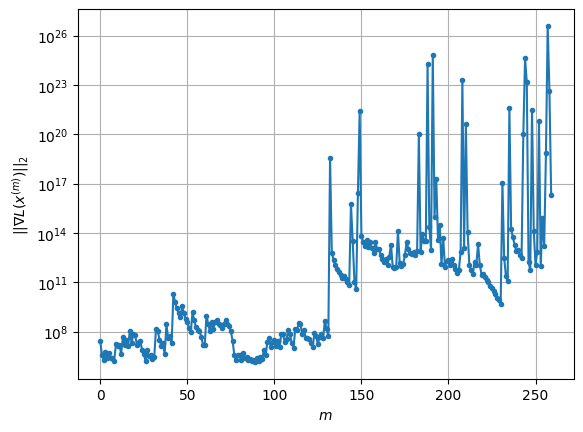

Windows:   3%|▎         | 13/386 [00:41<18:52,  3.04s/it]

Before applying the algorithm
Cost function: 1.620197410157956e+26
Gradient norm: 2.359439832941462e+16
Global relative error: 202182403223.36264
Position relative errors: 2311473444.8976607 m, 45012328039.293526 m, 44912630891.96184 m, 191217430833.3104 m

Iteration 1
Cost function: 6.070537415725512e+25 (-62.53%)
Gradient norm: 1.210216288460632e+16 (-48.71%)
Global relative error: 104923861581.09729 (-48.10%)
Position relative errors: 1546216118.9218075 m, 70642264097.87724 m, 70596248781.42458 m, 30310333427.854042 m

Iteration 2
Cost function: 2.6099015925817385e+25 (-57.01%)
Gradient norm: 7404327163238412.0 (-38.82%)
Global relative error: 64444693485.454285 (-38.58%)
Position relative errors: 1040849469.7285912 m, 30428904015.03517 m, 30437345702.997242 m, 47421928691.251495 m

Iteration 3
Cost function: 1.1670671982016927e+25 (-55.28%)
Gradient norm: 4853987736382282.0 (-34.44%)
Global relative error: 42295876289.70572 (-34.37%)
Position relative errors: 700611322.1438081 m, 2

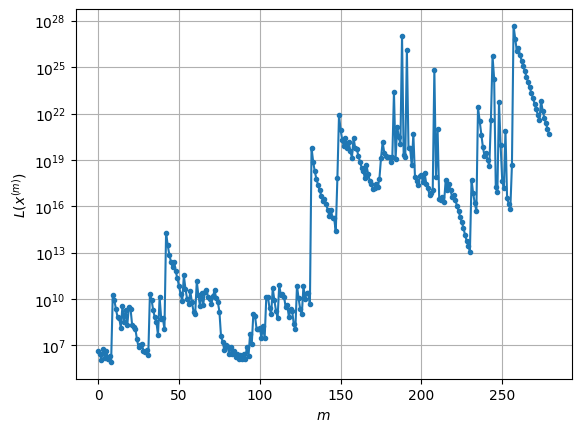

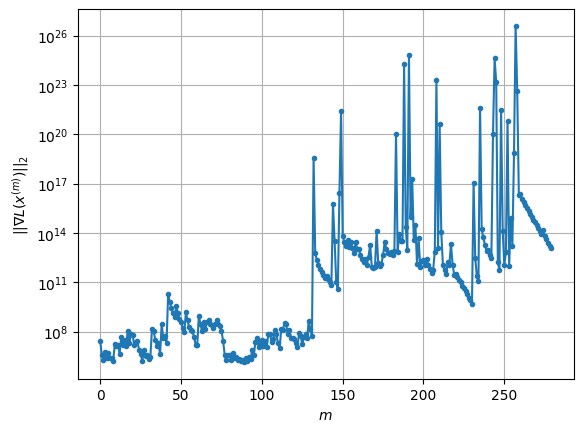

Windows:   4%|▎         | 14/386 [00:44<18:46,  3.03s/it]

Before applying the algorithm
Cost function: 3.335566960100578e+20
Gradient norm: 8169800394795.919
Global relative error: 14606840378.600973
Position relative errors: 245567483.30063686 m, 8309601931.715179 m, 8309531860.03869 m, 8671823149.774443 m

Iteration 1
Cost function: 1.4929510010358845e+20 (-55.24%)
Gradient norm: 5341907197702.288 (-34.61%)
Global relative error: 9803881911.759287 (-32.88%)
Position relative errors: 164902520.46215686 m, 5691551645.413768 m, 5691576048.651178 m, 5594692736.231394 m

Iteration 2
Cost function: 6.722730278611988e+19 (-54.97%)
Gradient norm: 3743071317684.792 (-29.93%)
Global relative error: 6552580468.23351 (-33.16%)
Position relative errors: 110235495.81359893 m, 3758098605.2236714 m, 3758113316.3899083 m, 3831084616.285493 m

Iteration 3
Cost function: 2.850794599872033e+19 (-57.59%)
Gradient norm: 2520581270218.298 (-32.66%)
Global relative error: 4249792165.1797533 (-35.14%)
Position relative errors: 71478746.63554375 m, 2414397507.92759 

/tmp/ipykernel_15190/2490028760.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=7.80118e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 12
Cost function: 1.737189294554826e+16 (-96.63%)
Gradient norm: 180165229991.82397 (-100.00%)
Global relative error: 102614068.23749086 (-34.49%)
Position relative errors: 2182960.1152070425 m, 58406862.98779625 m, 58429647.24008456 m, 60823026.83749148 m

Iteration 13
Cost function: 7757171818390008.0 (-55.35%)
Gradient norm: 65451114537.246925 (-63.67%)
Global relative error: 68387278.6144905 (-33.35%)
Position relative errors: 1170060.6069739205 m, 39538777.19994873 m, 39548244.71637668 m, 39345245.89065778 m

Iteration 14
Cost function: 3365554826599384.5 (-56.61%)
Gradient norm: 34675294179.58201 (-47.02%)
Global relative error: 44684196.11373132 (-34.66%)
Position relative errors: 756716.0657690257 m, 25382505.585911423 m, 25400821.002879288 m, 26582346.8923936 m

Iteration 15
Cost function: 1475914676424441.0 (-56.15%)
Gradient norm: 21656923258.63068 (-37.54%)
Global relative error: 29666963.428557344 (-33.61%)
Position relative errors: 492619.4798437075 m, 17145901.

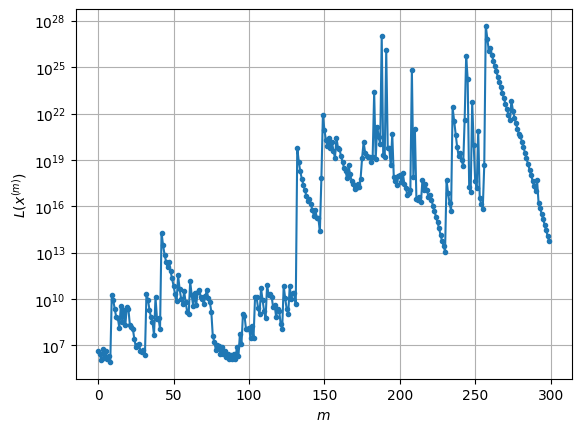

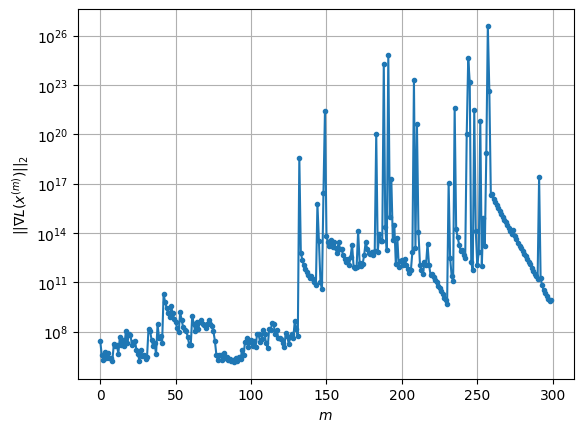

Windows:   4%|▍         | 15/386 [00:47<18:38,  3.02s/it]

Before applying the algorithm
Cost function: 41944775370835.805
Gradient norm: 12006561654.667698
Global relative error: 4917691.216343449
Position relative errors: 82331.66388443222 m, 2849934.19774215 m, 2845114.8393989895 m, 2821338.885006749 m

Iteration 1
Cost function: 1448399764880894.2 (3353.11%)
Gradient norm: 1078874493295407.2 (8985607.35%)
Global relative error: 3005545.934802936 (-38.88%)
Position relative errors: 50091.79804354202 m, 1664565.7544548386 m, 1691047.3228308752 m, 1843994.3451570654 m

Iteration 2
Cost function: 2.1199714075896266e+17 (14536.65%)
Gradient norm: 1.0473786062074574e+17 (9608.07%)
Global relative error: 2588641.764223479 (-13.87%)
Position relative errors: 48146.48936688396 m, 1278028.3578153127 m, 1448273.984494428 m, 1722739.3659185097 m

Iteration 3
Cost function: 1.625020135188808e+16 (-92.33%)
Gradient norm: 1800307111325514.0 (-98.28%)
Global relative error: 10272211.461008266 (296.82%)
Position relative errors: 377924.54162124696 m, 68289

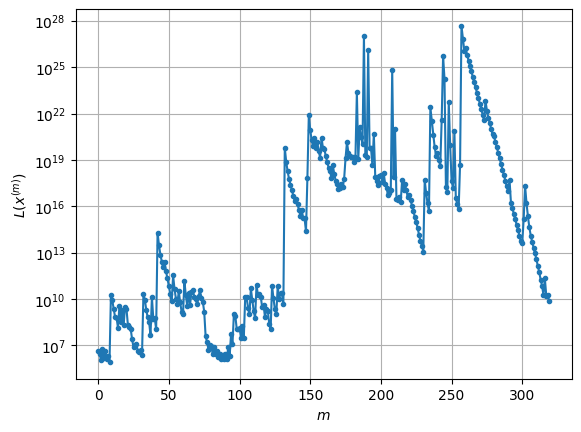

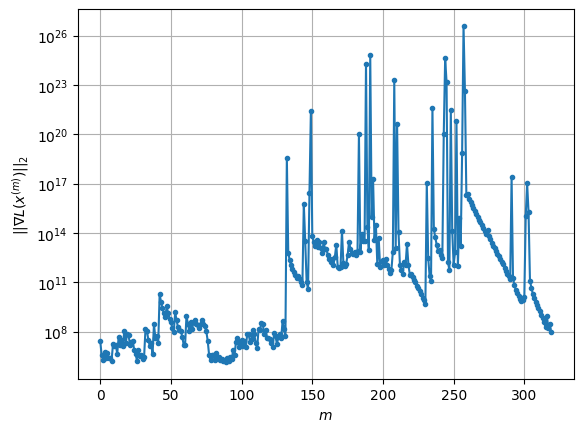

Windows:   4%|▍         | 16/386 [00:50<18:41,  3.03s/it]

Before applying the algorithm
Cost function: 7328054605.216548
Gradient norm: 99066550.7613706
Global relative error: 39409.74482007637
Position relative errors: 268.89303082168504 m, 13633.424356501431 m, 31984.02299289205 m, 18552.568687011237 m

Iteration 1
Cost function: 754562237239.0948 (10196.90%)
Gradient norm: 2332291392.5942855 (2254.27%)
Global relative error: 47536.05210514272 (20.62%)
Position relative errors: 320.11662180457455 m, 3953.3223718854183 m, 41238.54670646549 m, 23295.669582401682 m

Iteration 2
Cost function: 67410978048.5656 (-91.07%)
Gradient norm: 630873702.3491149 (-72.95%)
Global relative error: 25589.54674281703 (-46.17%)
Position relative errors: 210.47291047829515 m, 13230.18682210471 m, 13947.662948211078 m, 16885.43567702468 m

Iteration 3
Cost function: 9007022385.445059 (-86.64%)
Gradient norm: 159250736.03206137 (-74.76%)
Global relative error: 15936.14005894919 (-37.72%)
Position relative errors: 156.9901106905831 m, 7299.9802997263305 m, 6960.96

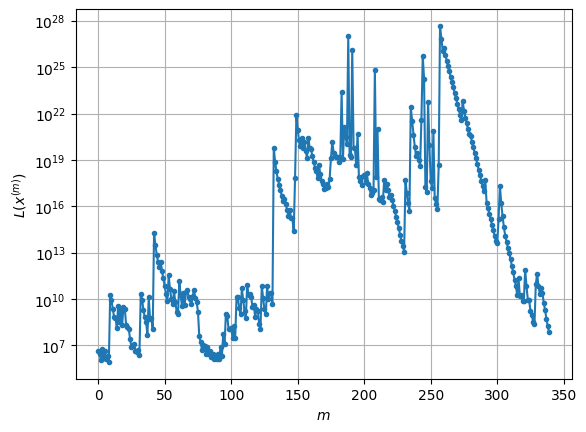

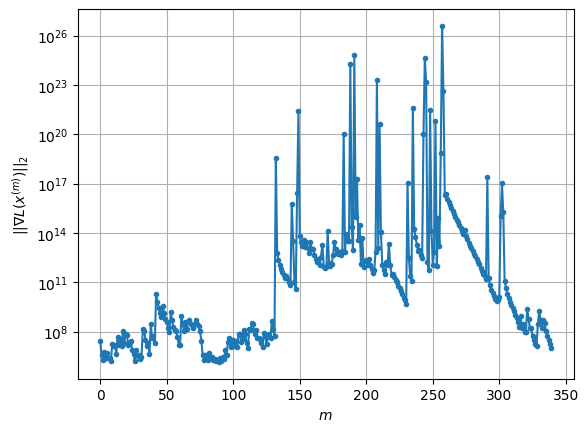

Windows:   4%|▍         | 17/386 [00:53<18:47,  3.06s/it]

Before applying the algorithm
Cost function: 87535474.79702047
Gradient norm: 11328602.374150977
Global relative error: 6767.387100957941
Position relative errors: 29.727146406251137 m, 2444.9302476463495 m, 3790.8455186340707 m, 5044.448039113323 m

Iteration 1
Cost function: 283759637.6698081 (224.17%)
Gradient norm: 20235358.089920804 (78.62%)
Global relative error: 11302.406733972915 (67.01%)
Position relative errors: 16.807367034339638 m, 3017.4306881289585 m, 2111.372134423108 m, 10685.500716431305 m

Iteration 2
Cost function: 267124357.7992979 (-5.86%)
Gradient norm: 32540801.097612616 (60.81%)
Global relative error: 10071.91569734751 (-10.89%)
Position relative errors: 28.203932372206435 m, 3994.172684190088 m, 8140.539613521681 m, 4383.974118606127 m

Iteration 3
Cost function: 179399635.94257385 (-32.84%)
Gradient norm: 15633649.099575644 (-51.96%)
Global relative error: 9885.798771472593 (-1.85%)
Position relative errors: 14.998568649720118 m, 2052.691551064955 m, 541.70591

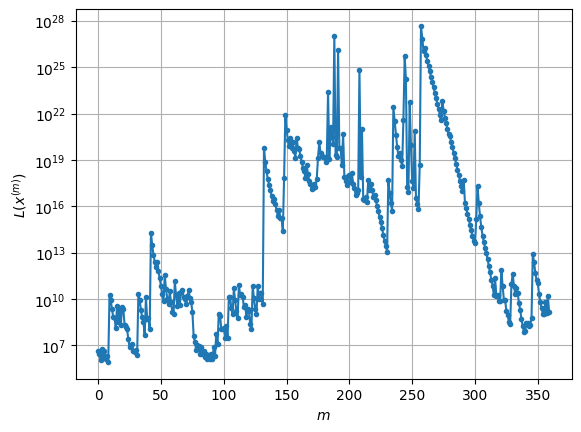

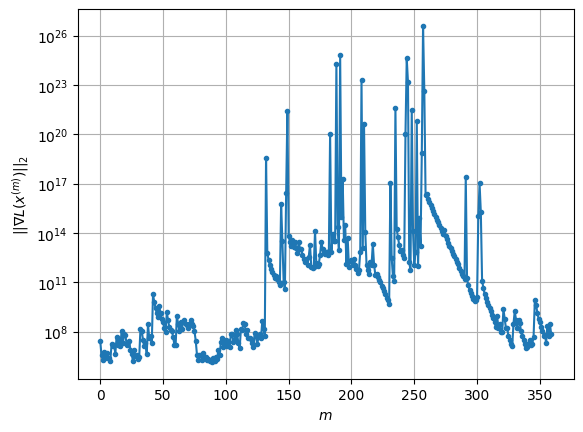

Windows:   5%|▍         | 18/386 [00:56<18:57,  3.09s/it]

Before applying the algorithm
Cost function: 1428566173.525398
Gradient norm: 79746207.89839813
Global relative error: 32982.82656019377
Position relative errors: 119.10965047850833 m, 9795.704079587164 m, 14573.330869262247 m, 27919.738185183778 m

Iteration 1
Cost function: 27113455775.582348 (1797.95%)
Gradient norm: 260906794.74492532 (227.17%)
Global relative error: 72903.07088397168 (121.03%)
Position relative errors: 200.1361416605487 m, 46233.398712321134 m, 53075.009224512694 m, 18981.434329025007 m

Iteration 2
Cost function: 1281993435.5099785 (-95.27%)
Gradient norm: 54783166.34664802 (-79.00%)
Global relative error: 28338.129997316446 (-61.13%)
Position relative errors: 217.43759950631937 m, 14586.416912742872 m, 13079.35157651099 m, 20473.42283000253 m

Iteration 3
Cost function: 15331465980.8648 (1095.91%)
Gradient norm: 106826431.10306177 (95.00%)
Global relative error: 68630.72582356317 (142.19%)
Position relative errors: 319.41888702668507 m, 42333.8445677448 m, 42525

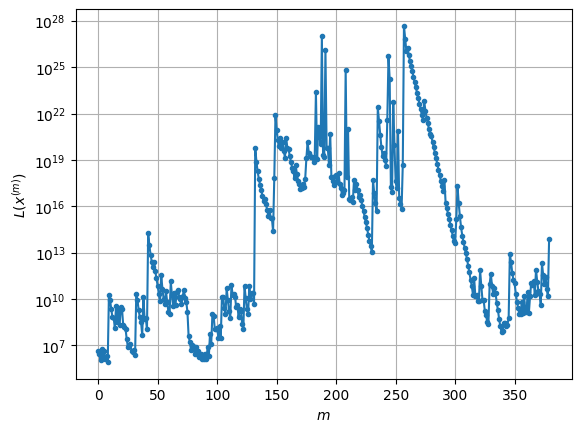

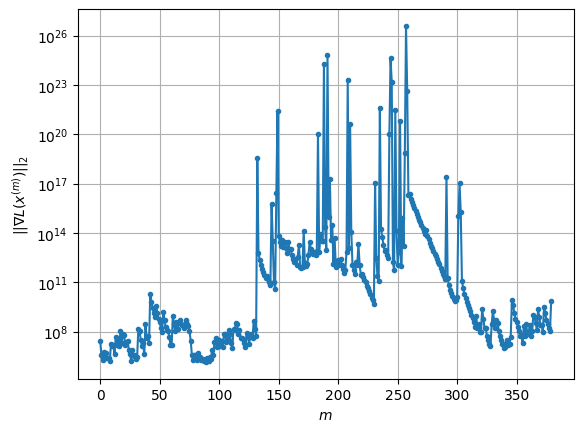

Windows:   5%|▍         | 19/386 [00:59<18:53,  3.09s/it]

Before applying the algorithm
Cost function: 55246433777219.93
Gradient norm: 2601463142.227992
Global relative error: 3670387.1847446556
Position relative errors: 37584.11255622518 m, 3656664.311453676 m, 71008.2055753954 m, 306619.0149541832 m

Iteration 1
Cost function: 9092481742779.05 (-83.54%)
Gradient norm: 792524985.1746947 (-69.54%)
Global relative error: 1871672.170948267 (-49.01%)
Position relative errors: 24317.430342182957 m, 130891.28259047681 m, 1392316.6225453287 m, 1243731.4080226868 m

Iteration 2
Cost function: 2167783551169.672 (-76.16%)
Gradient norm: 367804619.05819404 (-53.59%)
Global relative error: 1120269.9330102773 (-40.15%)
Position relative errors: 17768.088189936974 m, 872302.0081937566 m, 469968.68988059985 m, 522399.35172906175 m

Iteration 3
Cost function: 778623024014.832 (-64.08%)
Gradient norm: 222260535.28520674 (-39.57%)
Global relative error: 736651.4560527727 (-34.24%)
Position relative errors: 11960.615125345988 m, 347880.9818942219 m, 461512.17

/tmp/ipykernel_15190/2490028760.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=2.26251e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 6
Cost function: 1.786749497737621e+19 (-95.09%)
Gradient norm: 13776179422271.895 (-100.00%)
Global relative error: 384579038.6132392 (54136.68%)
Position relative errors: 16299379.368371736 m, 381717920.8255944 m, 43344193.289847225 m, 5771180.956259746 m

Iteration 7
Cost function: 2.16827489226439e+18 (-87.86%)
Gradient norm: 3927075927475.6206 (-71.49%)
Global relative error: 174595388.85415375 (-54.60%)
Position relative errors: 2384668.4716950674 m, 12035529.882154413 m, 129972131.61610259 m, 115921648.43569794 m

Iteration 8
Cost function: 3.5073889018655597e+17 (-83.82%)
Gradient norm: 1407869150683.122 (-64.15%)
Global relative error: 98822277.44298851 (-43.40%)
Position relative errors: 1579961.9290598712 m, 82722010.05673575 m, 35870892.33920164 m, 40411063.87261106 m

Iteration 9
Cost function: 8.352310493460878e+16 (-76.19%)
Gradient norm: 548534982532.67413 (-61.04%)
Global relative error: 63046559.000329845 (-36.20%)
Position relative errors: 1064617.750367495

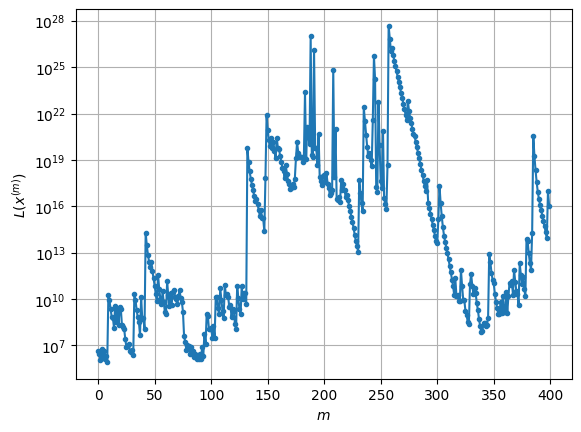

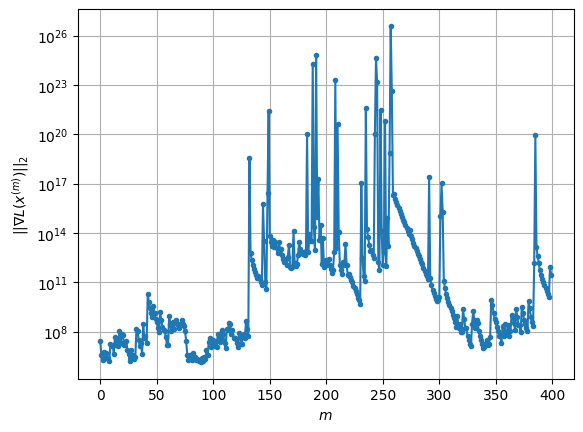

Windows:   5%|▌         | 20/386 [01:02<18:48,  3.08s/it]

Before applying the algorithm
Cost function: 1.5571895329741588e+16
Gradient norm: 349160885698.3483
Global relative error: 8739949.191892266
Position relative errors: 53831.71985789936 m, 7029610.7540793605 m, 2815621.736643902 m, 4362118.611206236 m

Iteration 1
Cost function: 1765354855665631.5 (-88.66%)
Gradient norm: 113350580054.16544 (-67.54%)
Global relative error: 3372342.2278797464 (-61.41%)
Position relative errors: 37412.35769356402 m, 493689.1602299496 m, 969126.8420090456 m, 3191646.8943067207 m

Iteration 2
Cost function: 247967510791185.53 (-85.95%)
Gradient norm: 38322611751.794586 (-66.19%)
Global relative error: 1728696.2288654384 (-48.74%)
Position relative errors: 24972.043733302155 m, 1415359.6448677415 m, 954151.9310161341 m, 271520.8490453227 m

Iteration 3
Cost function: 55098688440238.5 (-77.78%)
Gradient norm: 14637557422.980366 (-61.80%)
Global relative error: 1084183.354747751 (-37.28%)
Position relative errors: 17078.962179556 m, 423839.49996295996 m, 5658

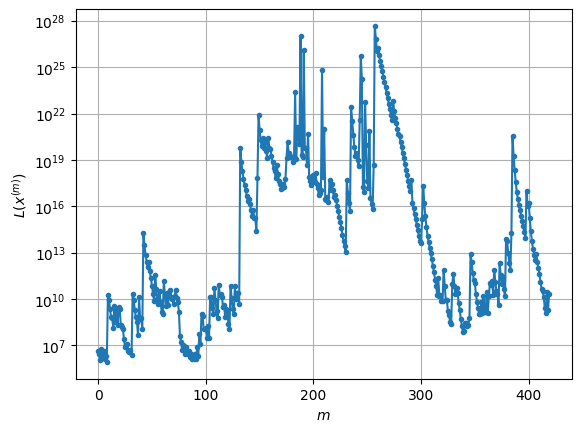

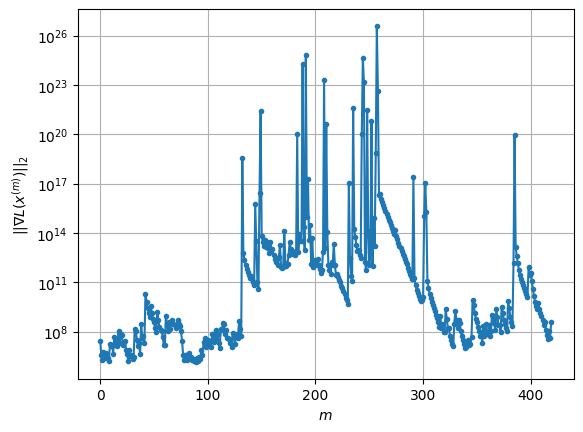

Windows:   5%|▌         | 21/386 [01:05<18:43,  3.08s/it]

Before applying the algorithm
Cost function: 30308318555.8084
Gradient norm: 447972323.80946934
Global relative error: 40533.71985948036
Position relative errors: 329.5815105350524 m, 19683.65403418103 m, 25139.407294208904 m, 24967.897346329817 m

Iteration 1
Cost function: 51592798063.99078 (70.23%)
Gradient norm: 180373304.6907524 (-59.74%)
Global relative error: 112091.1358808271 (176.54%)
Position relative errors: 922.7967802333293 m, 105195.78092389274 m, 29028.581117534563 m, 25586.38642076915 m

Iteration 2
Cost function: 2878056469.648409 (-94.42%)
Gradient norm: 56326256.169187844 (-68.77%)
Global relative error: 51915.73408190568 (-53.68%)
Position relative errors: 466.0119117179162 m, 8153.271839592622 m, 36872.11894550932 m, 35622.68849480535 m

Iteration 3
Cost function: 17141654160.746323 (495.60%)
Gradient norm: 330873453.7509743 (487.42%)
Global relative error: 41093.3905520751 (-20.85%)
Position relative errors: 286.92030558893043 m, 16691.98427789147 m, 25166.3092400

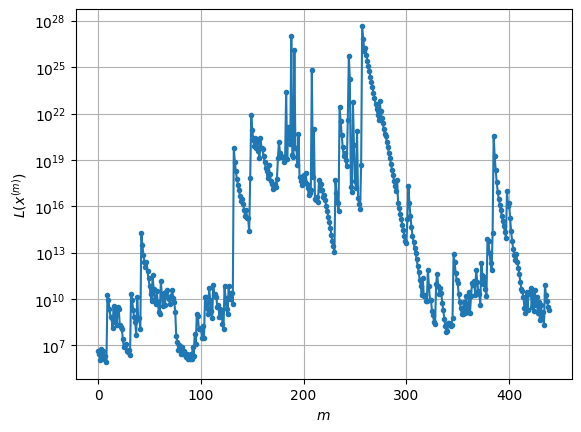

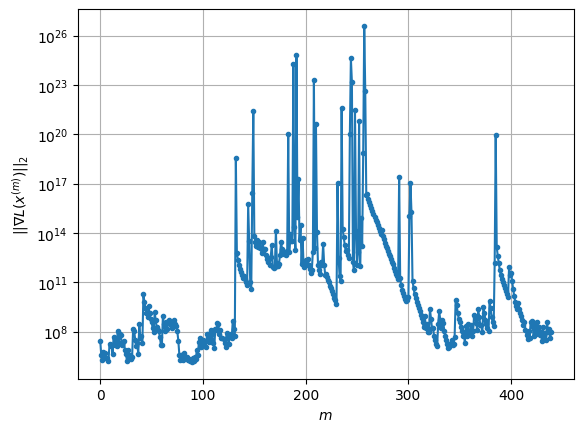

Windows:   6%|▌         | 22/386 [01:09<18:50,  3.11s/it]

Before applying the algorithm
Cost function: 3044608110.489911
Gradient norm: 133009117.50765748
Global relative error: 20172.30485782206
Position relative errors: 132.98319446823146 m, 6638.927429622457 m, 13608.639705054627 m, 13327.364754777376 m

Iteration 1
Cost function: 87966720247.1878 (2789.26%)
Gradient norm: 110353411.8101987 (-17.03%)
Global relative error: 169627.6470003156 (740.89%)
Position relative errors: 552.0657577256303 m, 13910.782313191297 m, 33416.743543077464 m, 165719.19964070292 m

Iteration 2
Cost function: 17270199565.9575 (-80.37%)
Gradient norm: 81513473.11132881 (-26.13%)
Global relative error: 109851.82089967873 (-35.24%)
Position relative errors: 1038.756639379456 m, 63801.126935920816 m, 85243.5574446483 m, 27004.158199623485 m

Iteration 3
Cost function: 181825576058.9757 (952.83%)
Gradient norm: 1068742963.2089207 (1211.12%)
Global relative error: 97412.17583589183 (-11.32%)
Position relative errors: 887.4741554977074 m, 54214.24320812034 m, 44257.74

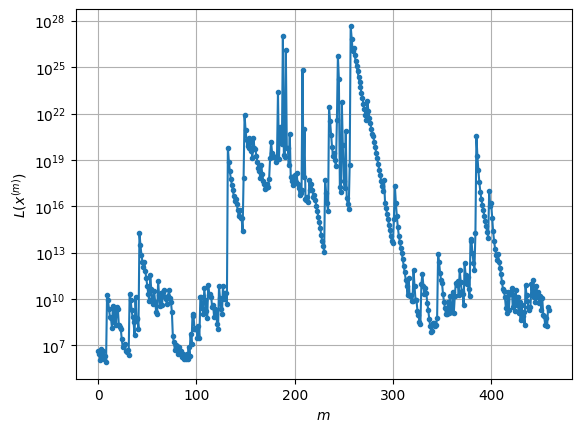

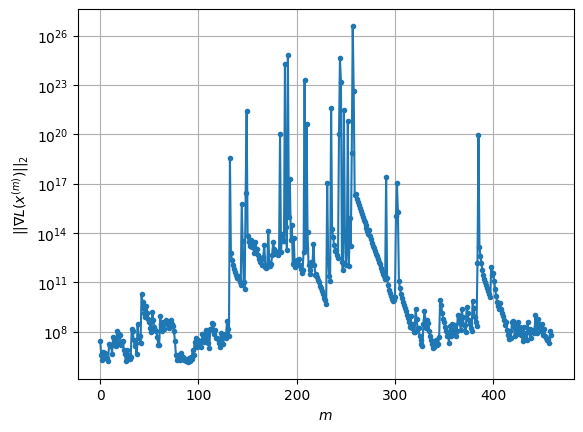

Windows:   6%|▌         | 23/386 [01:12<19:04,  3.15s/it]

Before applying the algorithm
Cost function: 1486924723.2263992
Gradient norm: 44805765.888080046
Global relative error: 36376.68377371178
Position relative errors: 87.16590871552917 m, 23017.761385075384 m, 13200.749517744203 m, 24883.17686653236 m

Iteration 1
Cost function: 2295436393.9066167 (54.37%)
Gradient norm: 124759189.19446817 (178.44%)
Global relative error: 30961.675719734532 (-14.89%)
Position relative errors: 83.02385157792608 m, 6874.135347193619 m, 25459.358309980085 m, 16222.923910716883 m

Iteration 2
Cost function: 199019523367.89984 (8570.23%)
Gradient norm: 1367480029.7649484 (996.10%)
Global relative error: 37199.102954879076 (20.15%)
Position relative errors: 111.43052201274539 m, 28475.55796599968 m, 18169.19625217788 m, 15578.25345713663 m

Iteration 3
Cost function: 63209499472971.35 (31660.45%)
Gradient norm: 21365448415.29269 (1462.40%)
Global relative error: 896383.9729515585 (2309.69%)
Position relative errors: 4530.0729352304725 m, 8896.338112644715 m, 3

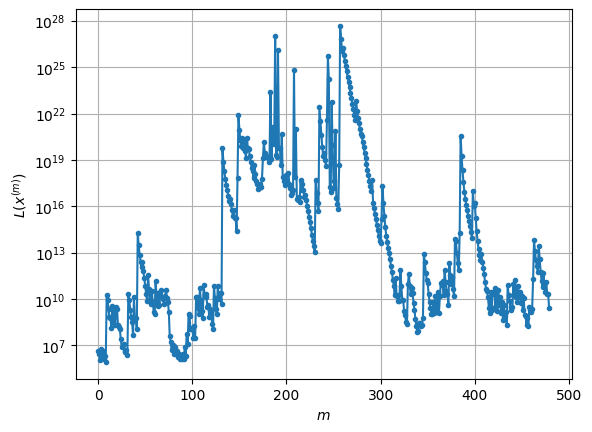

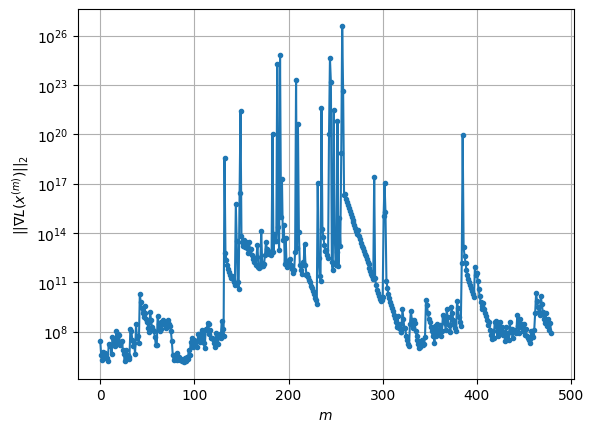

Windows:   6%|▌         | 24/386 [01:15<18:56,  3.14s/it]

Before applying the algorithm
Cost function: 2374900680.9551635
Gradient norm: 90967202.56812961
Global relative error: 31944.790206910016
Position relative errors: 374.11666148386234 m, 21177.88263397744 m, 19041.826016367093 m, 14464.473039388193 m

Iteration 1
Cost function: 46097944419.4296 (1841.05%)
Gradient norm: 277844413.1212417 (205.43%)
Global relative error: 97868.55593134365 (206.37%)
Position relative errors: 758.7315478012686 m, 84898.80105530677 m, 36961.244962953366 m, 31680.20184511945 m

Iteration 2
Cost function: 11891036935.946701 (-74.20%)
Gradient norm: 174471164.0766502 (-37.21%)
Global relative error: 50860.447379825 (-48.03%)
Position relative errors: 467.8240923327775 m, 24325.90129215916 m, 30620.145138970554 m, 32514.20167839511 m

Iteration 3
Cost function: 3824955369.522057 (-67.83%)
Gradient norm: 88242574.18153004 (-49.42%)
Global relative error: 23920.32616935617 (-52.97%)
Position relative errors: 222.33917307330208 m, 15758.14952527204 m, 8975.490084

Iteration 18
Cost function: 1784848922.6960433 (-48.51%)
Gradient norm: 33827365.5212487 (-9.15%)
Global relative error: 56527.841310029085 (-20.25%)
Position relative errors: 414.3248730048861 m, 18088.06553646821 m, 34005.80856041722 m, 41371.95713888573 m

STOP on Iteration 19
Cost function = 409918616.25674343 (-77.03%)
Gradient norm = 18178893.478186056 (-46.26%)
Global relative error = 42094.756480951124 (-25.53%)
Final position relative errors: 210.18195203295375 m, 8428.459906818585 m, 27027.610337368224 m, 31151.04798407342 m



KeyboardInterrupt: 

In [20]:
# Main execution loop
def run_estimation():
    
    Y = np.zeros((9, 1, T))
    for t in range(T):
        Y[:, :, t] = h(X_true[:, :, t]) + np.random.normal(0, np.sqrt(np.diag(R)).reshape((9, 1)), size=(9, 1))
        
    # Initialize storage for results
    X_est_mm = np.zeros_like(X_true)
    X_est_mm[:, :, 0] = X_est[:, :, 0]  # Use same initial conditions
    
    # Storage for errors
    errors_chief_mm = []
    errors_deputy1_mm = []
    errors_deputy2_mm = []
    errors_deputy3_mm = []
    
    # Initialize solver
    solver = approxH_Newton()
    
    # Sliding window estimation
    for t in tqdm(range(T - W + 1), desc="Windows", leave=False):
        # Get measurements for current window
        Y_window = Y[:, :, t:t + W]
        
        # Initial guess is the previous estimate propagated forward
        if t == 0:
            x_init = X_est[:, :, t]
        else:
            x_init = X_est_mm[:, :, t]
        
        # Solve the optimization problem
        x_sol = solver.solve(x_init, Y_window, X_true[:, :, t])
        
        # Store the solution
        X_est_mm[:, :, t] = x_sol
        
        # Plot the results
        give_me_the_plots(solver.cost_function_values, solver.grad_norm_values)
        
        # Propagate solution to next timestep if not at the end
        if t < T - W:
            X_est_mm[:, :, t + 1] = SatelliteDynamics().x_new(dt, x_sol)
        
        # Calculate and store errors
        error_chief = np.linalg.norm(X_est_mm[:3, :, t] - X_true[:3, :, t])
        error_deputy1 = np.linalg.norm(X_est_mm[6:9, :, t] - X_true[6:9, :, t])
        error_deputy2 = np.linalg.norm(X_est_mm[12:15, :, t] - X_true[12:15, :, t])
        error_deputy3 = np.linalg.norm(X_est_mm[18:21, :, t] - X_true[18:21, :, t])
        
        errors_chief_mm.append(error_chief)
        errors_deputy1_mm.append(error_deputy1)
        errors_deputy2_mm.append(error_deputy2)
        errors_deputy3_mm.append(error_deputy3)
    
    return X_est_mm, errors_chief_mm, errors_deputy1_mm, errors_deputy2_mm, errors_deputy3_mm

# Run the estimation
X_est_mm, errors_chief_mm, errors_deputy1_mm, errors_deputy2_mm, errors_deputy3_mm = run_estimation()

# Print RMSE for each satellite
print("RMSE after convergence:")
print(f"Chief: {np.sqrt(np.mean(np.array(errors_chief_mm[T_RMSE:])**2)):.2f} m")
print(f"Deputy 1: {np.sqrt(np.mean(np.array(errors_deputy1_mm[T_RMSE:])**2)):.2f} m")
print(f"Deputy 2: {np.sqrt(np.mean(np.array(errors_deputy2_mm[T_RMSE:])**2)):.2f} m")
print(f"Deputy 3: {np.sqrt(np.mean(np.array(errors_deputy3_mm[T_RMSE:])**2)):.2f} m")

In [ ]:
dev_chief = errors_chief_mm
dev_deputy1 = errors_deputy1_mm
dev_deputy2 = errors_deputy2_mm
dev_deputy3 = errors_deputy3_mm

# MATLAB default color cycle
matlab_default_colors = [
    [0, 0.4470, 0.7410],  # blue
    [0.8500, 0.3250, 0.0980],  # orange
    [0.9290, 0.6940, 0.1250],  # yellow
    [0.4940, 0.1840, 0.5560],  # purple
    [0.4660, 0.6740, 0.1880],  # green
    [0.3010, 0.7450, 0.9330],  # light blue
    [0.6350, 0.0780, 0.1840],  # red
]
# Set the color cycle in Matplotlib to match MATLAB's default
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=matlab_default_colors)

time = np.arange(0, T) / dt
algorithm = "approx$H$-Newton"

# Plot positions based on screen size
fig_width = 2 * 6.4  # in inchesa
fig_height = 2 * 4.8  # in inches

# Create a 2 by 2 figure
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# Plot 1: Chief
axs[0, 0].plot(time, dev_chief_initial, ".-", label="Initial")
axs[0, 0].plot(time[:K - W + 1], dev_chief, ".-", label=algorithm)
axs[0, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 0].grid(True, which="both")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{C}_1} - \\mathbf{r}_k^{\\mathcal{C}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[0, 0].set_ylim([1e-2, 1e3])
axs[0, 0].tick_params(axis="both", which="both", direction="in")
axs[0, 0].legend(fontsize=12)
axs[0, 0].set_title("Chief")

# Plot 2: Deputy 1
axs[0, 1].plot(time, dev_deputy1_initial, ".-", label="Initial")
axs[0, 1].plot(time[:K - W + 1], dev_deputy1, ".-", label=algorithm)
axs[0, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 1].grid(True, which="both")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_1} - \\mathbf{r}_k^{\\mathcal{D}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[0, 1].set_ylim([1e-1, 1e3])
axs[0, 1].tick_params(axis="both", which="both", direction="in")
axs[0, 1].legend(fontsize=12)
axs[0, 1].set_title("Deputy 1")

# Plot 3: Deputy 2
axs[1, 0].plot(time, dev_deputy2_initial, ".-", label="Initial")
axs[1, 0].plot(time[:K - W + 1], dev_deputy2, ".-", label=algorithm)
axs[1, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 0].grid(True, which="both")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_2} - \\mathbf{r}_k^{\\mathcal{D}_2}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[1, 0].set_ylim([1e-1, 1e3])
axs[1, 0].tick_params(axis="both", which="both", direction="in")
axs[1, 0].legend(fontsize=12)
axs[1, 0].set_title("Deputy 2")

# Plot 4: Deputy 3
axs[1, 1].plot(time, dev_deputy3_initial, ".-", label="Initial")
axs[1, 1].plot(time[:K - W + 1], dev_deputy3, ".-", label=algorithm)
axs[1, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 1].grid(True, which="both")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_3} - \\mathbf{r}_k^{\\mathcal{D}_3}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[1, 1].set_ylim([1e-1, 1e3])
axs[1, 1].tick_params(axis="both", which="both", direction="in")
axs[1, 1].legend(fontsize=12)
axs[1, 1].set_title("Deputy 3")

fig.suptitle(f"Formation {formation}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

In [ ]:
import pickle
from datetime import datetime

# Fill the dictionary
data = {}
data["true"] = X_true
data[0] = X_est_mm

# Save to pickle file
with open(
    f'approxh_newton3_form{formation}_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pkl',
    "wb",
) as file:
    pickle.dump(data, file)